In [1]:
#imports and configs
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import scipy.integrate

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Numerical Analysis of Temperature on a Heat Fin

In [2]:
# Plate dimensions
pdim = ((0,20), (0,10)) # [=] (x cm, y cm)

# Thermal diffusivity, alpha
alpha = 97*1/100 # [=] cm^2/s

## **Section (a)**

At steady, state (i.e., t --> $\infty$) , $\frac{\partial T}{\partial t}$ goes to 0

Thus, the heat distribution in the plate takes the form of an elliptic PDE, namely the laplace equation.

$\alpha$ dependence does not affect for steady state

##### Functions **build_T0** and **lm_steady_state** defined

In [3]:
# Returns 2D matrix for plate with 4 side boundary conditions and middle T0

def build_T0(x_range, y_range, bx, by, T0, hx, hy):
    # range definitions
    xvec = np.arange(x_range[0], x_range[1]+ hx, hx)
    yvec = np.arange(y_range[0], y_range[1] + hy, hy)
    nx = xvec.shape[0]
    ny = yvec.shape[0]
    
    # initial matrix
    T_0 = np.ones((yvec.shape[0], xvec.shape[0]))*T0
    # initial plate bc
    T_0[-1, :] = np.ones((1, xvec.shape[0]))*bx[1]
    T_0[:,0] = np.ones((1, yvec.shape[0]))*by[0]
    T_0[:, -1] = np.ones((1, yvec.shape[0]))*by[1]
    # bottom bc
    T_0[0,:] = np.ones((1, xvec.shape[0]))*bx[0]
    
    
    Xmat, Ymat = np.meshgrid(xvec, yvec)
    
    return T_0, nx, ny, xvec, yvec, Xmat, Ymat

# Note: I chose to represent the edges as the first 
# and last indecies of x and y inside the 10x20 plate
# which becomes a better approximation for smaller h

In [4]:
# steady state solution finder - no insulation
# returns solved 2D matrix for steady state plate temperature
# uses liebmann method with optional overrelaxation approximations
def lm_steady_state(x_range, y_range, bx, by, T0, h, tol, overrelaxed=True, lmda=1.6138383838383838):
    #obtain initial matrix
    T_0_elements = build_T0(x_range, y_range, bx, by, T0, h, h)
    T, nx, ny, xvec, yvec = T_0_elements[:5]

    #error analysis definitions
    rel_errors = np.zeros_like(T)
    rel_errors[1:ny-1, 1:nx-1] = np.ones_like(T[1:ny-1, 1:nx-1])*100 #arbitrary initial error value
    max_errs = [100]
    stime = time.time()
    
    #matrix population
    if overrelaxed:
        while max_errs[-1] > tol:
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    old_val = T[j, i]
                    new_val = 1/4*(T[j, i+1] + T[j, i-1] + T[j+1, i] + T[j-1, i])
                    new_val = lmda*new_val + (1-lmda)*old_val
                    rel_errors[j, i] = np.abs((new_val - old_val)/new_val)
                    T[j, i] = new_val
            max_errs.append(np.amax(rel_errors))
    else:
        while max_errs[-1] > tol:
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    old_val = T[j, i]
                    new_val = 1/4*(T[j, i+1] + T[j, i-1] + T[j+1, i] + T[j-1, i])
                    rel_errors[j, i] = np.abs((new_val - old_val)/new_val)
                    T[j, i] = new_val
            max_errs.append(np.amax(rel_errors))
    etime = time.time()
    
    return [T, xvec, yvec, np.array(max_errs), (etime-stime)]

##### Conditions and section (a) instantiation

In [5]:
#section a parameters
xrange, yrange = pdim
er_tol = 10**(-5) #chosen for convergence

x_bcs_a = (600, 300) # (T(x0), T(xf)) [=] (K, K)
y_bcs_a = (300, 300) # (T(y0), T(yf)) [=] (K, K)
T_init_a = 300 # [=] K ; initial plate temperature
sq_interval_a = 1 # [=] cm ; h for hxh cells, arbitrarily chosen

#function call for steady state
Tssa = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, sq_interval_a, er_tol)
Ta, xveca, yveca, max_errs_a, time_elapsed_a = Tssa

##### Steady State Contour Plotting

Section (a) call performance
	run time: 0.02 s
	number of matrix iterations: 32


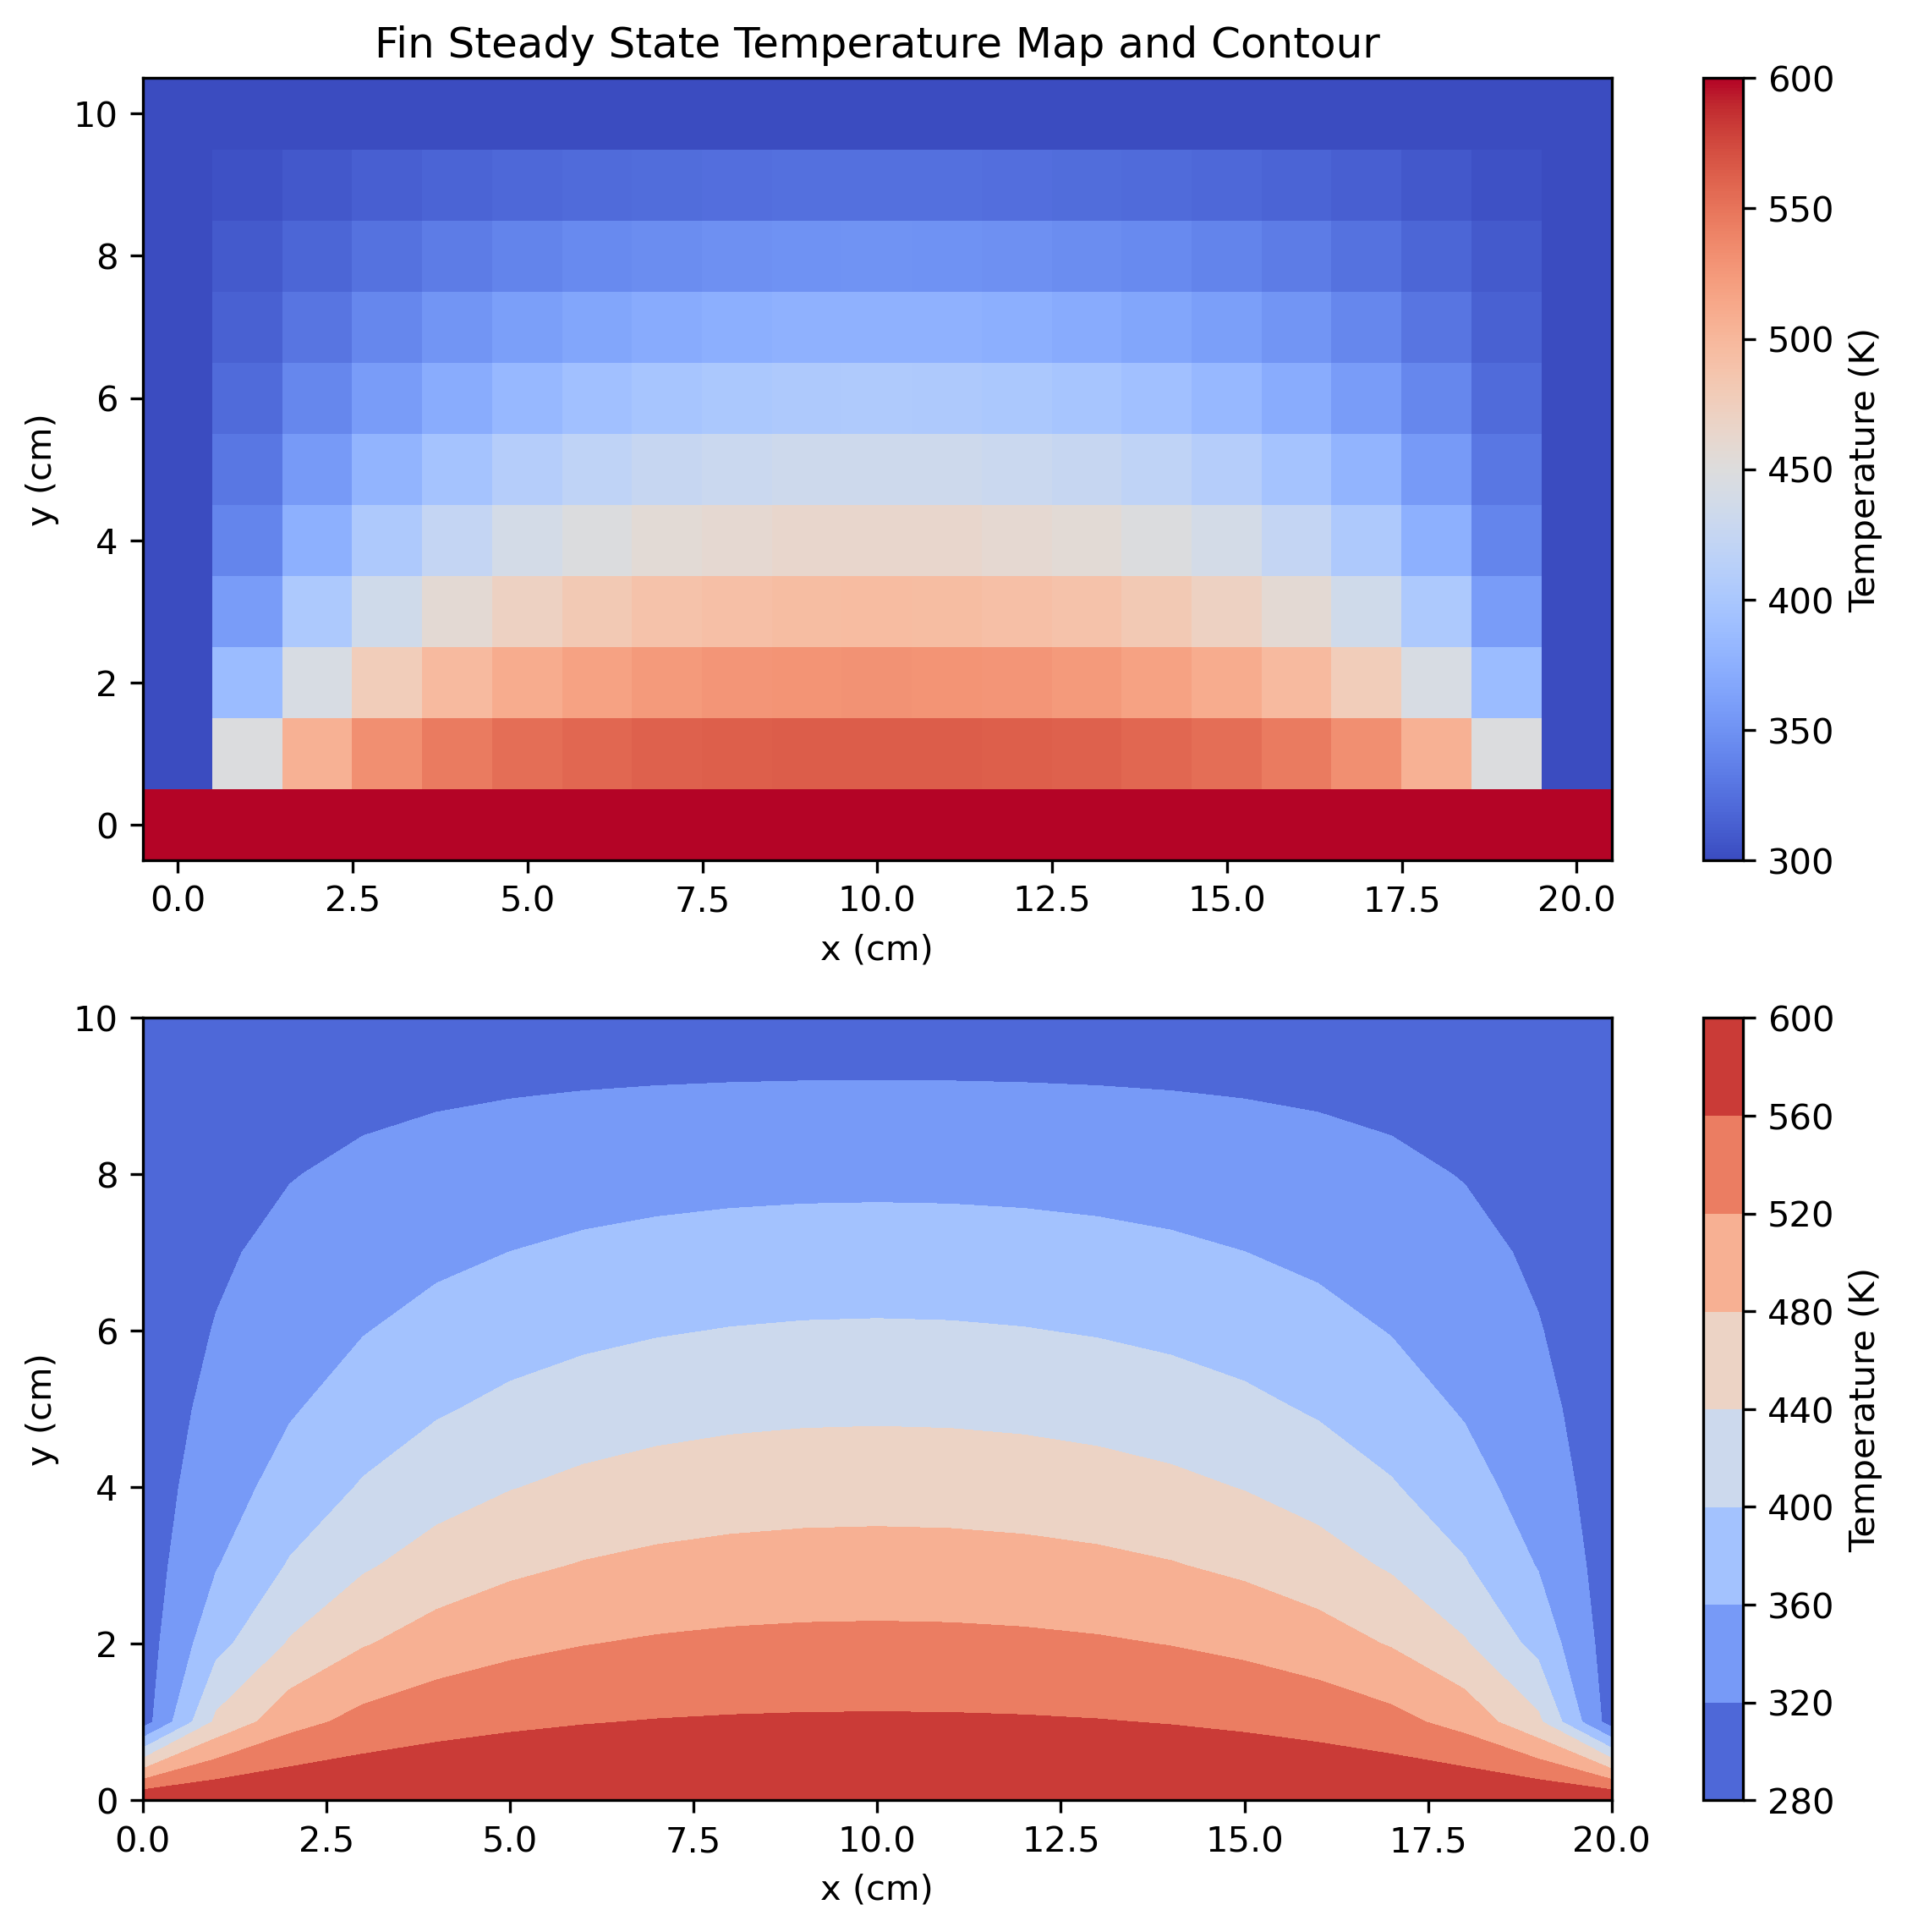

In [6]:
#Contour plotting
Xa, Ya = np.meshgrid(xveca, yveca)

fig1 = plt.figure(figsize = (8,11))
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)

#for color interpolated pcolormesh, shading = 'gouraud'
p1 = ax1.pcolormesh(Xa, Ya, Ta, cmap = plt.cm.coolwarm, shading = 'auto')
cb1 = fig1.colorbar(p1, ax=ax1, label='Temperature (K)')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')

p2 = ax2.contourf(Xa, Ya, Ta, cmap=plt.cm.coolwarm)
cb2 = fig1.colorbar(p2, ax=ax2, label='Temperature (K)')
ax2.set_xlabel('x (cm)')
ax2.set_ylabel('y (cm)')

ax1.set_title("Fin Steady State Temperature Map and Contour")
plt.tight_layout()

print('Section (a) call performance')
print(f"\trun time: {time_elapsed_a:.2f} s")
print(f"\tnumber of matrix iterations: {max_errs_a.size}")

##### Analysis of overrelaxation lambdas and time for convergence

best lambda value: 1.613076923076923


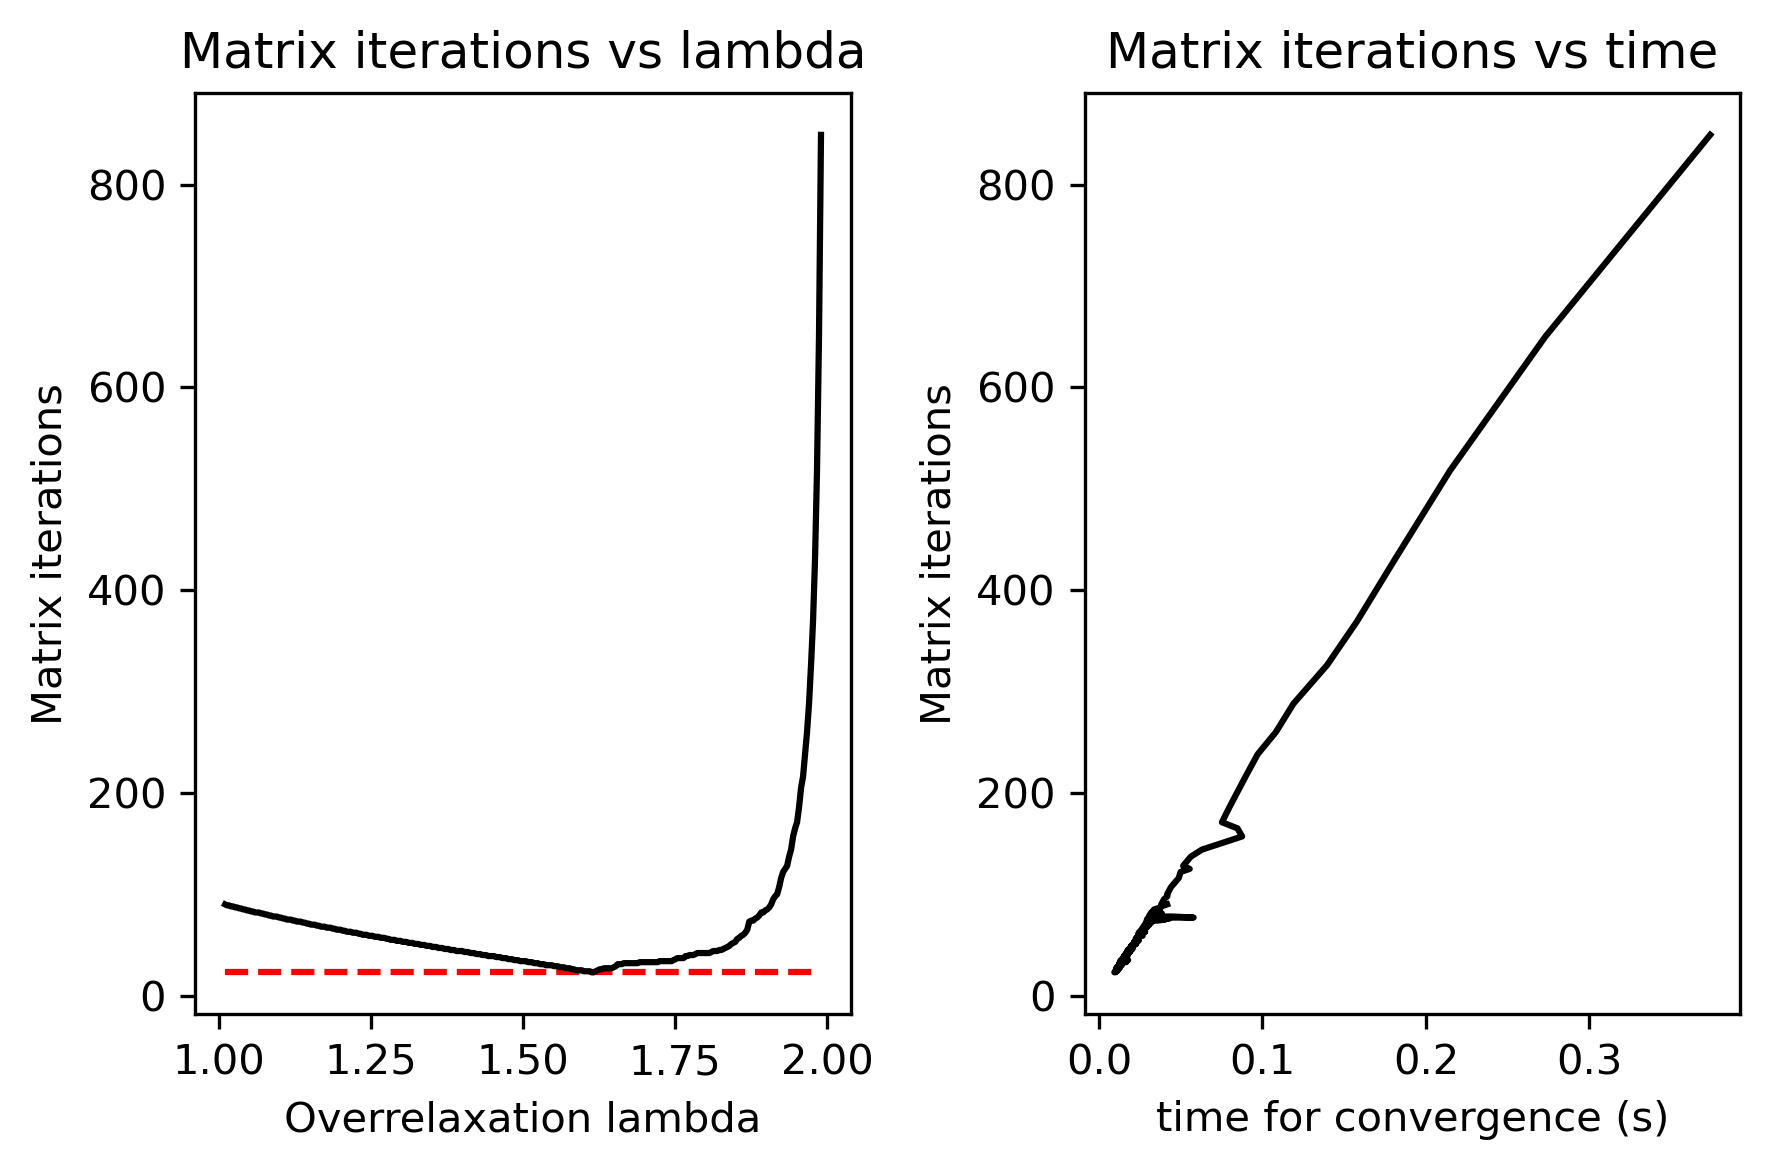

In [7]:
#best lambda for overrelaxed
lambdavec = np.linspace(1.01, 1.99, 300)
lmda_num_matricies = []
matricies_time = []

for i in lambdavec:
    T_a_i_elements = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, 1, 10**-4, overrelaxed=True, lmda=i)
    lmda_num_matricies.append(T_a_i_elements[3].size)
    matricies_time.append(T_a_i_elements[4])

best_lambda = lambdavec[np.argmin(lmda_num_matricies)]

figaa, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(lambdavec, lmda_num_matricies, 'k-')
ax1.hlines(min(lmda_num_matricies), lambdavec[0], lambdavec[-1], 'r', linestyle='--')
ax1.set_ylabel('Matrix iterations')
ax1.set_xlabel('Overrelaxation lambda')
ax1.set_title('Matrix iterations vs lambda')

ax2.plot(matricies_time, lmda_num_matricies, 'k')
ax2.set_xlabel('time for convergence (s)')
ax2.set_ylabel('Matrix iterations')
ax2.set_title('Matrix iterations vs time')

plt.tight_layout()
print(f'best lambda value: {best_lambda}') #somewhat close to the golden ratio

From the left subplot, we see that the number of matrix iterations is minimized for one choice of lambda: best_lambda = 1.6138

As a result of this analysis, I set the default lamda value to best_lambda, in the definition of the **lm_steady_state** function. (note: the best lambda may vary with different choices of h, and different boundary conditions; I expect them to still be close to 1.6138)

From the right subplot, as we would expect, the time for convergence is proportional to the number of matrix iterations. Thus, matrix iterations and time for convergence will be used interchangeablly in the subsequent analysis

##### Analysis of convergence with and without overrelaxed simplification

Text(0.5, 1.0, 'Convergence with and without overrelaxtion simplification')

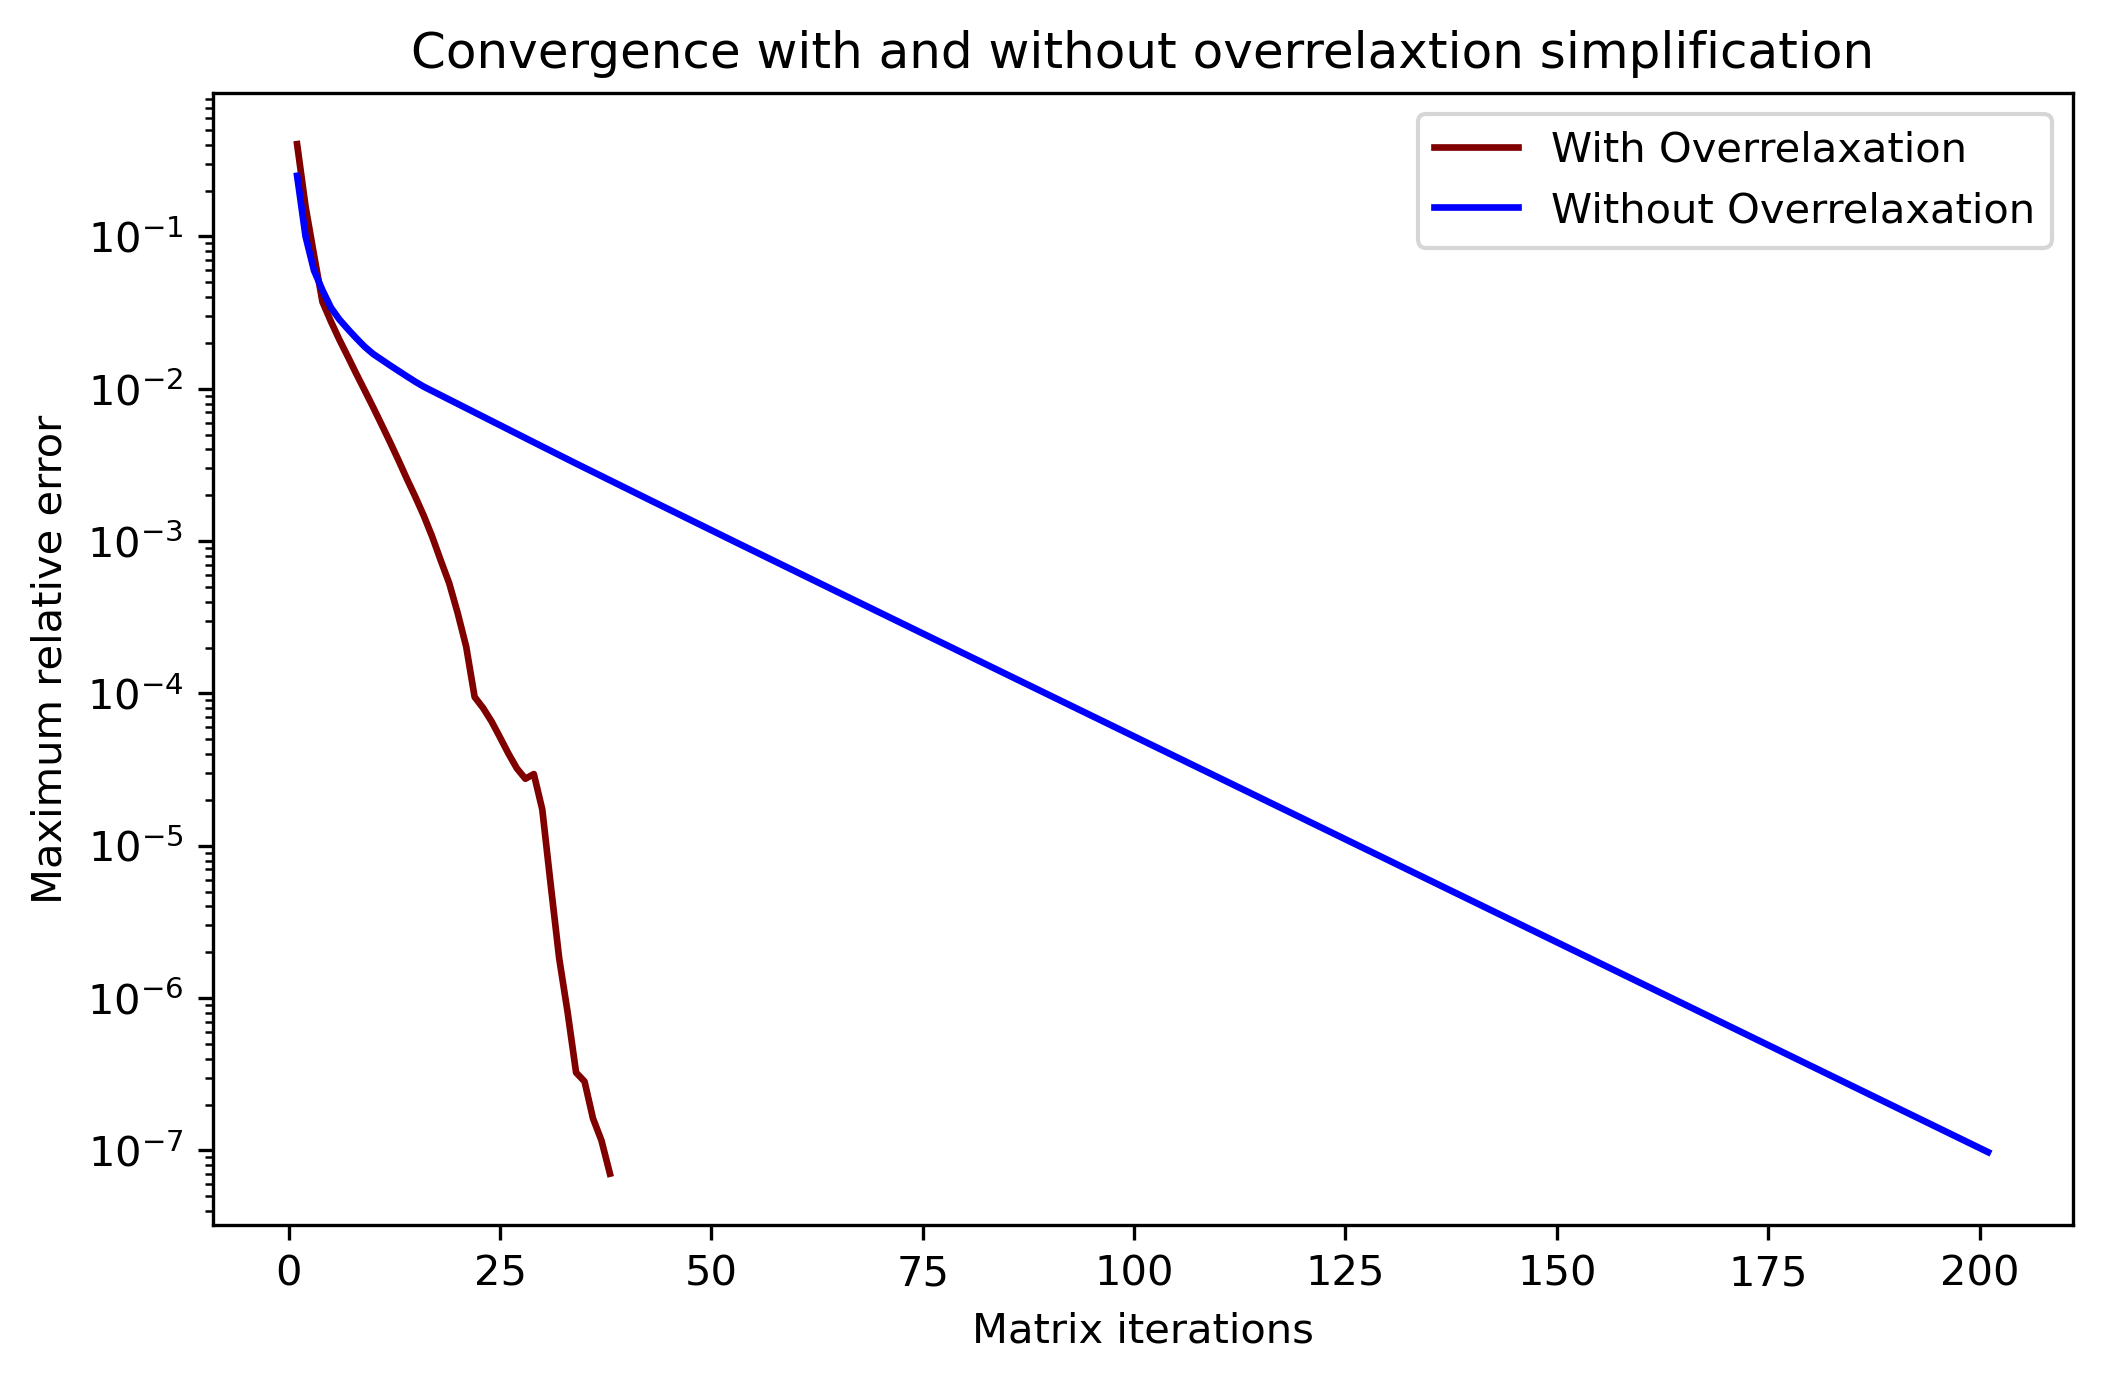

In [8]:
#with overrelaxed and best_lambda
Tssa_or = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, sq_interval_a, 10**-7, overrelaxed=True, lmda=best_lambda)
max_errs_a_or = Tssa_or[3]
#wihtout overrelaxed
Tssa_not_or = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, sq_interval_a, 10**-7, overrelaxed=False)
max_errs_a_not_or = Tssa_not_or[3]

# iterations
fig2 = plt.figure(figsize=(8,5))
ax1 = fig2.add_subplot()
ax1.semilogy(range(1, max_errs_a_or.size), max_errs_a_or[1:], color='maroon', linewidth='1.6', label = 'With Overrelaxation')
ax1.semilogy(range(1, max_errs_a_not_or.size), max_errs_a_not_or[1:], color='blue', linewidth='1.6', label = 'Without Overrelaxation')
ax1.set_xlabel('Matrix iterations')
ax1.set_ylabel("Maximum relative error")
ax1.legend()
ax1.set_title('Convergence with and without overrelaxtion simplification')

#### Analysis of computational complexity scaling with h

Text(0.5, 1.0, 'h values vs computational complexity')

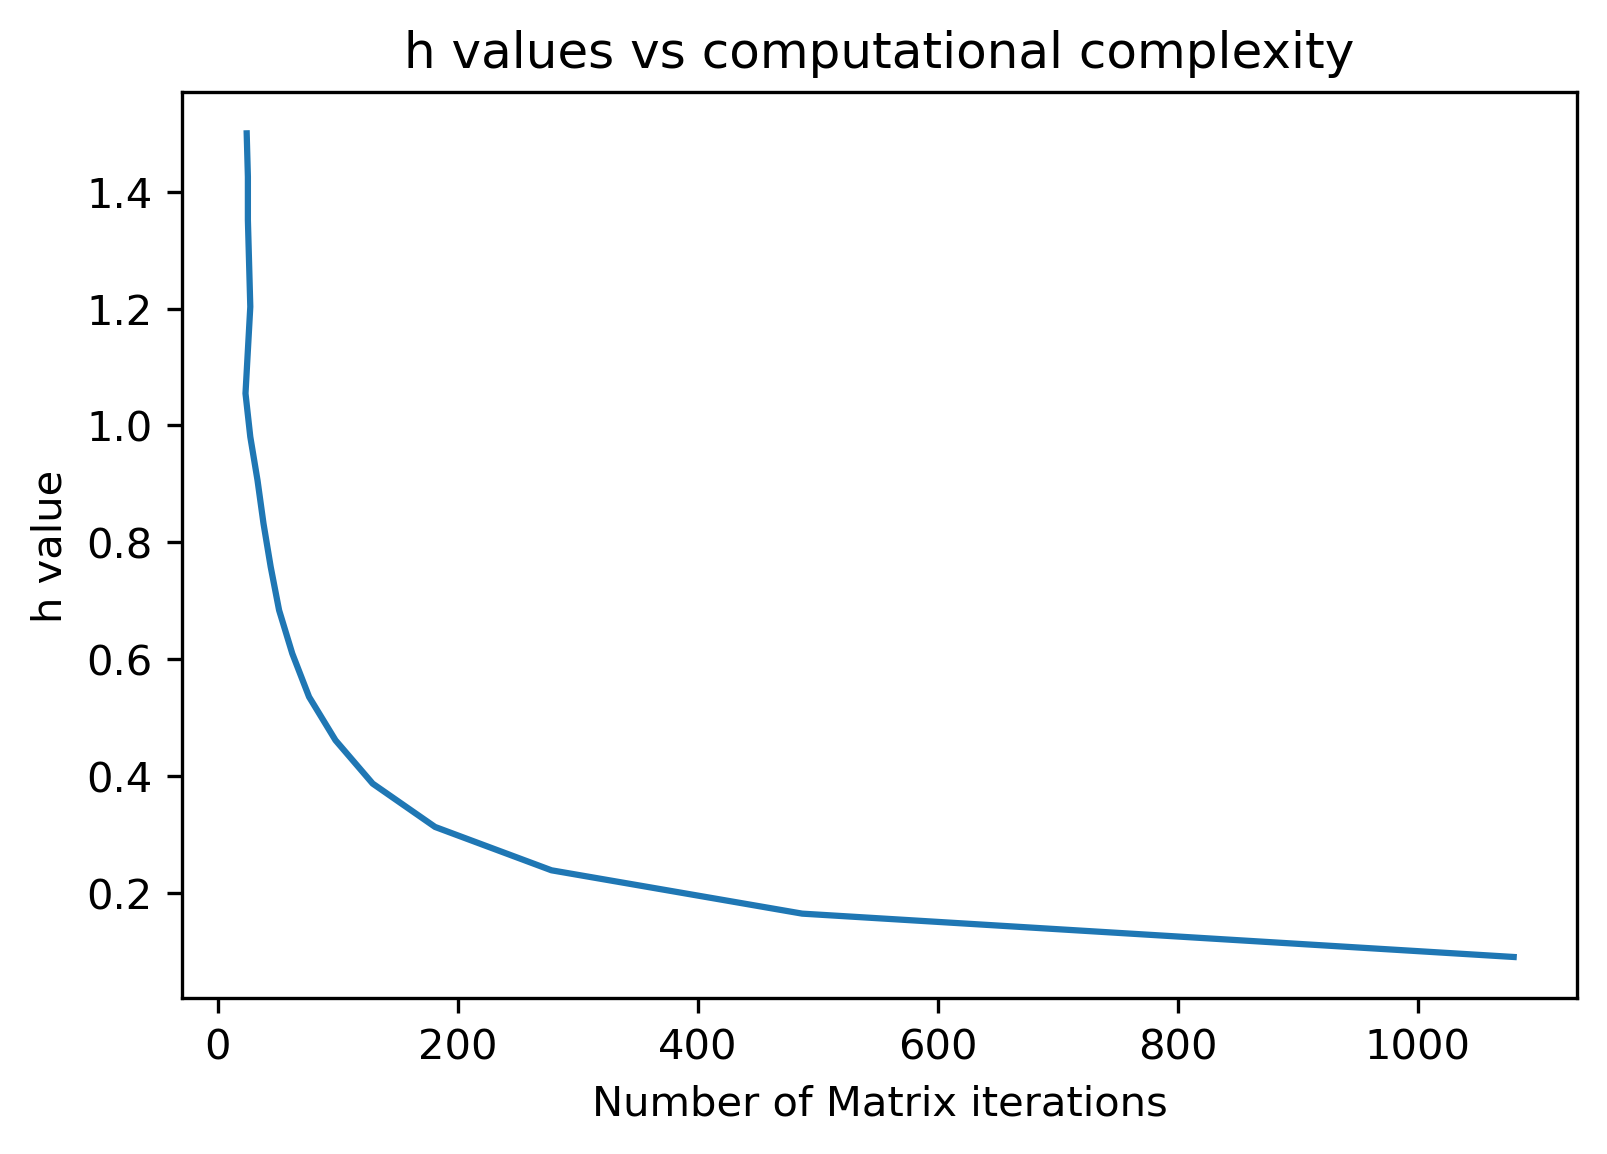

In [9]:
#h versus convergence with best_lambda
hvec = np.linspace(1.5, 0.09, 20)
h_num_matricies = []

for i in hvec:
    T_a_i_elements = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, i, 10**(-4), overrelaxed=True)
    h_num_matricies.append(T_a_i_elements[3].size)

plt.plot(h_num_matricies, hvec)
plt.xlabel('Number of Matrix iterations')
plt.ylabel('h value')
plt.title('h values vs computational complexity')

As a result, I only make solution calls for h bigger than h = 0.2 cm in my solutions - beyond that, the CPU time becomes exorbitantly large vs the increased resolution

More optimized methods or greater computational power would be needed to decrease the step size much below this.

##### Plotting X cross sections of T vs y

Text(0, 0.5, 'T_y (K)')

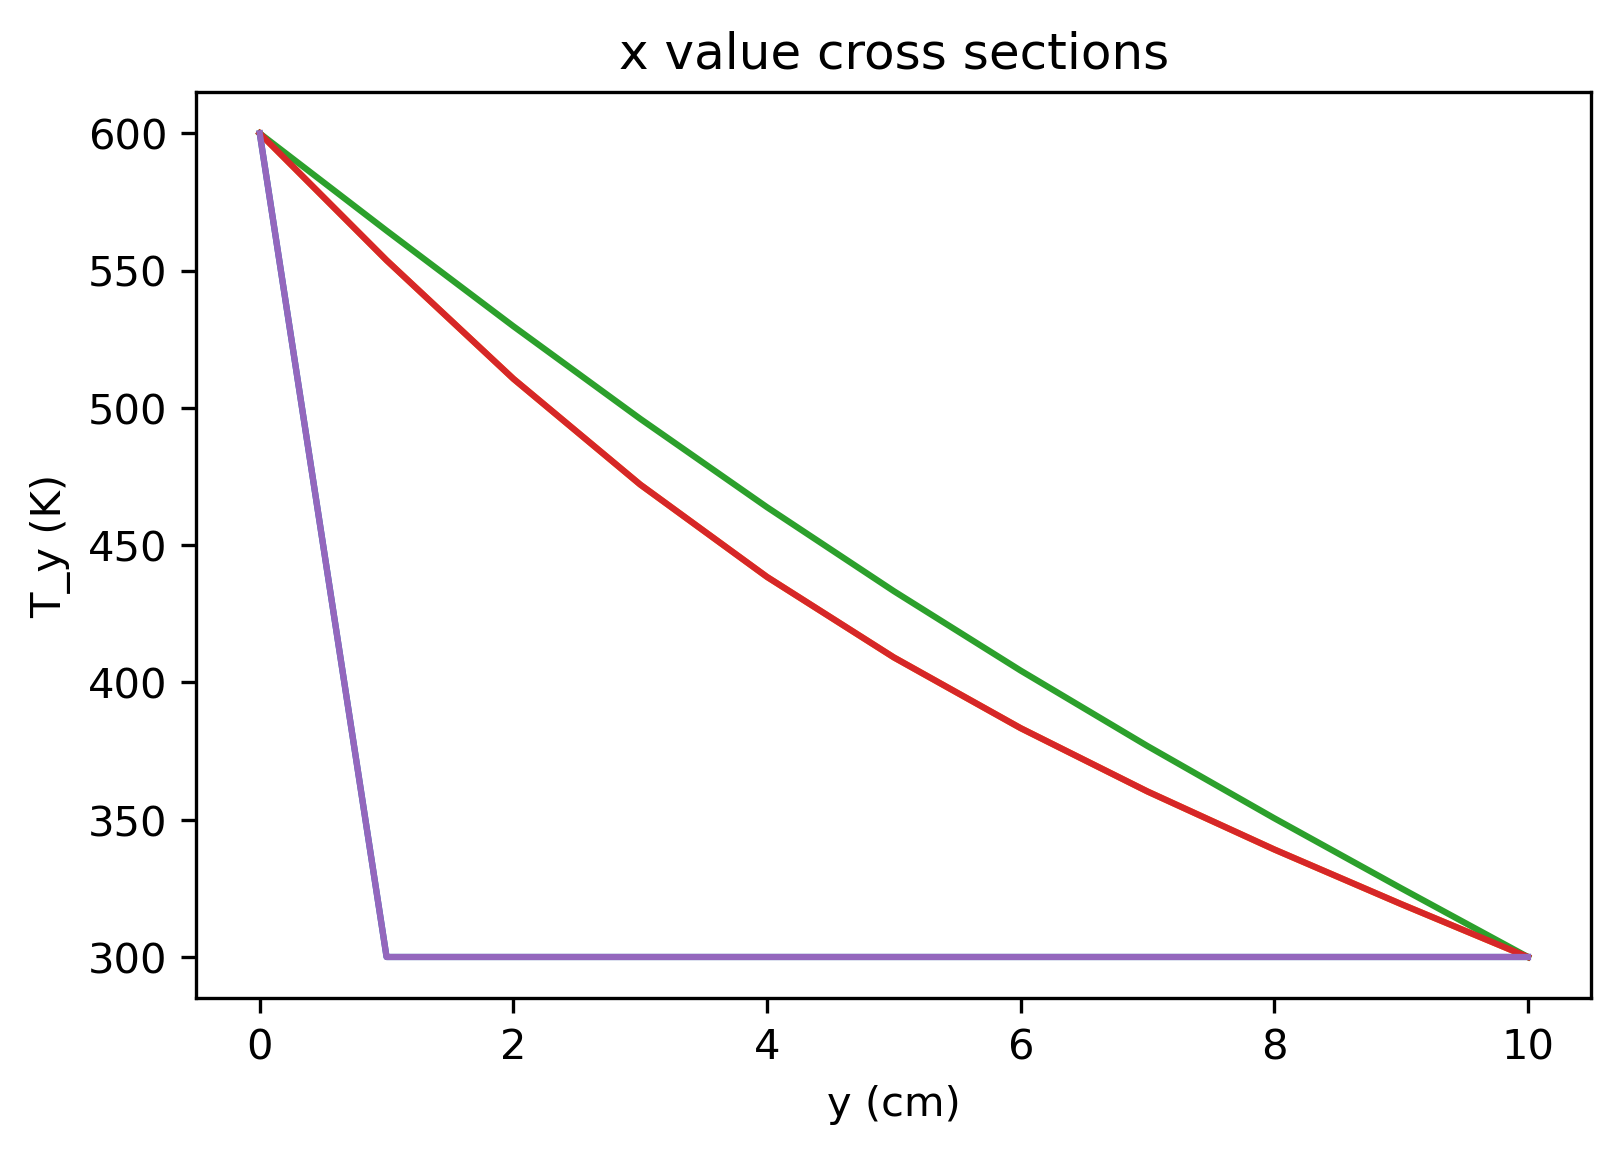

In [10]:
# xval cross sections of temperature in solution
for i in Ta.transpose()[::5]:
    plt.plot(yveca, i)
plt.title('x value cross sections')
plt.xlabel('y (cm)')
plt.ylabel('T_y (K)')

# could try to interpolate the shape of the thermoclines

## **Section (b)**

##### Function **q** defined

In [11]:
# takes solved plate temperature profile and returns heat per time density
# returns matricies of the magnitudes of q, q_x, and q_y in K/m^2
def q(T, hx, hy, k_fourier):
    ny, nx = T.shape
    q_matx = np.zeros_like(T)
    q_maty = np.zeros_like(T)
    q_mat = np.zeros_like(T)
    # qx and qy definitions are out of limits at the boundaries
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            # divide by 100 for q units of K/m^2 when using k_fourier of W/mK
            qx = -k_fourier*(T[j, i+1] - T[j, i-1])/(2*hx)/100
            qy = -k_fourier*(T[j+1, i] - T[j-1, i])/(2*hx)/100
            q_matx[j, i], q_maty[j, i] = qx, qy
            
            q_mat[j,i] = 1/2*(qx**2 + qy**2)**(1/2)
    
    return q_mat, q_matx, q_maty

##### conditions and section (b) instantiation for steady-state T and $\vec{q}$ solutions

In [12]:
k_plate = 240 #[W/m K]

T_ss_b = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, 0.7, er_tol)
Tb, xvecb, yvecb, max_errs_b, time_elapsed_b = T_ss_b
q_matrix = q(Tb, 0.7, 0.7, k_plate)

##### Steady-state $\vec{q}$ quiver plot

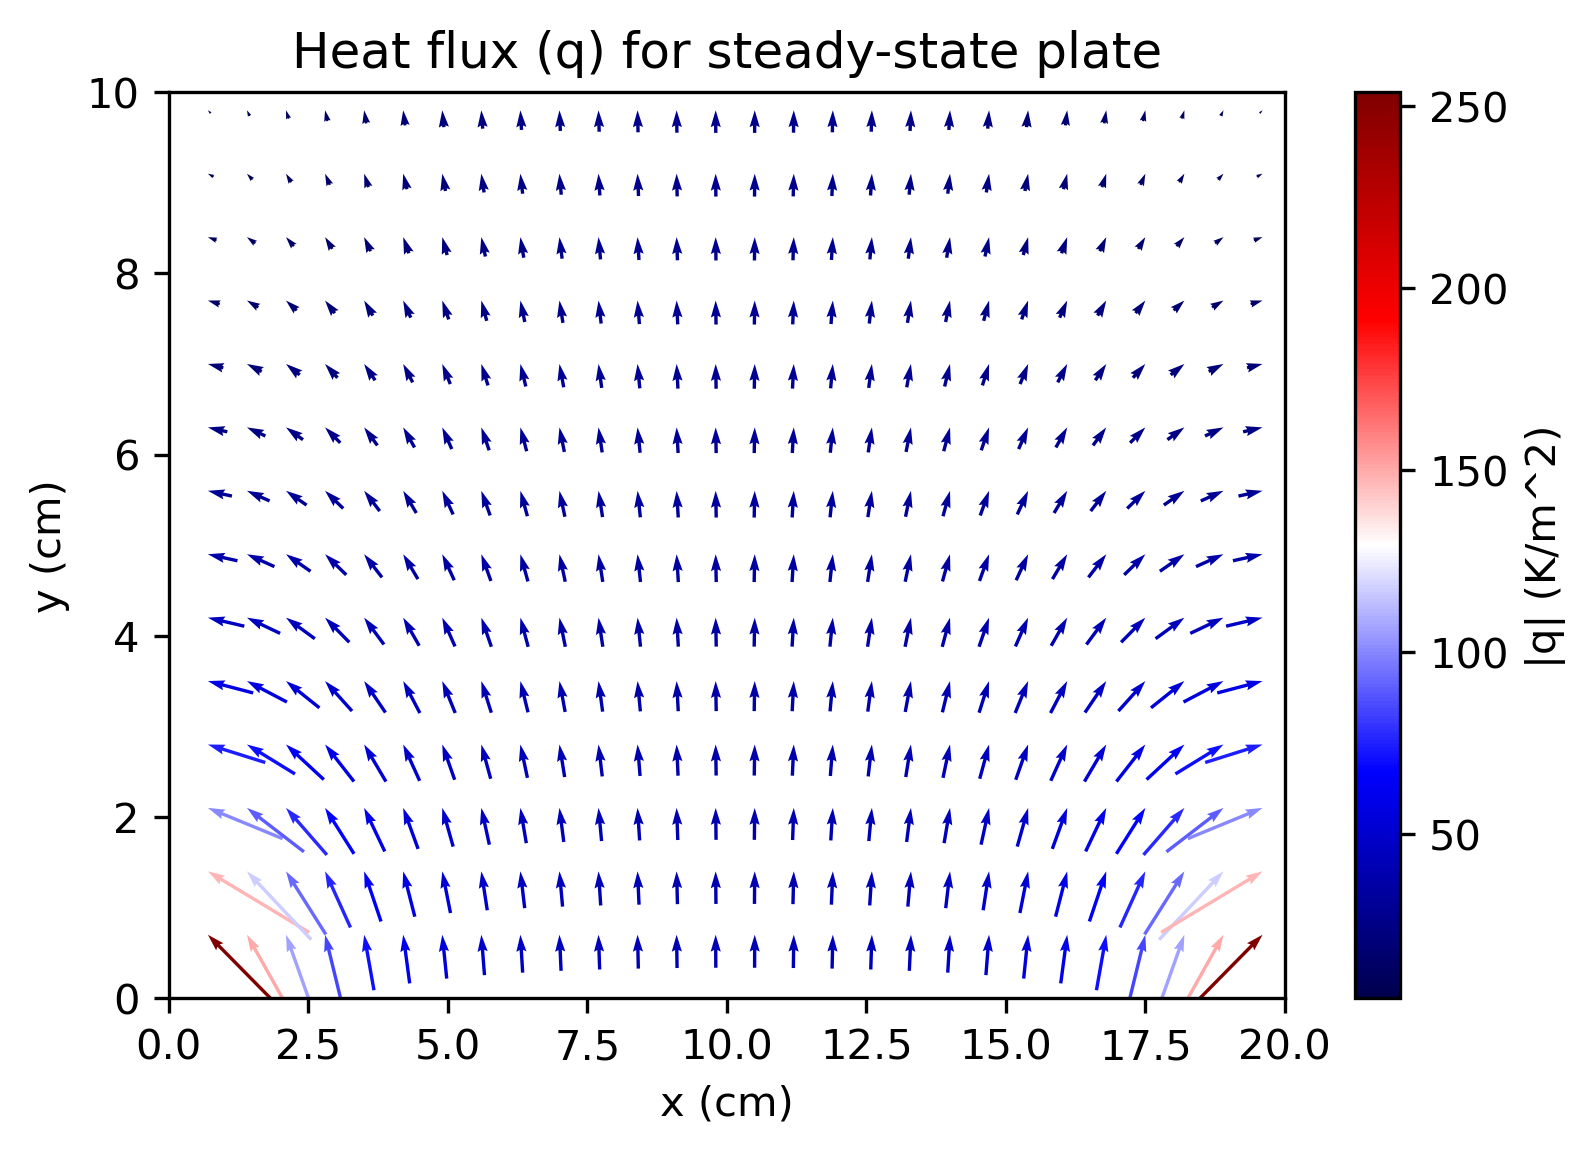

In [13]:
Xb, Yb = np.meshgrid(xvecb, yvecb)
fig3 = plt.figure()
ax1 = fig3.add_subplot()

# quiver for differentiable region
# could also set pivot = 'tail'
q1 = ax1.quiver(Xb[1:-1,1:-1], Yb[1:-1,1:-1], q_matrix[1][1:-1,1:-1], q_matrix[-1][1:-1,1:-1], q_matrix[0][1:-1,1:-1], cmap=plt.cm.seismic, pivot='tip')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')
ax1.set_title("Heat flux (q) for steady-state plate")
ax1.set_xlim(0,20)
ax1.set_ylim(0,10)
p3 = fig3.colorbar(q1, ax=ax1, label = '|q| (K/m^2)')

## **Section (c)**

##### Function **cdif_plate_evolution** defined

In [14]:
#uses central difference approximations to find the time evolution of T profile
#Takes, initial T profile and returns T_plate solutions between t0 and tf
def cdif_plate_evolution(T_0, hx, hy, t0, tf, a, err_stop=False, tol=10**(-4)):
    
    ny, nx = T_0.shape
    #optimal convergence ∆t criteria
    ht = 1/48*((hx)**2+(hy**2))/a
    tvec = np.arange(t0, tf, ht)
    nt = tvec.shape[0]
    
    T_t = np.array([T_0 for i in range(nt)])
    if not err_stop:
        for l in range(1, nt):
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    d2_Tx = (T_t[l-1, j, i+1] - 2*T_t[l-1, j, i] + T_t[l-1, j, i-1])/hx**2
                    d2_Ty = (T_t[l-1, j+1, i] - 2*T_t[l-1, j, i] + T_t[l-1, j-1, i])/hy**2

                    T_t[l, j, i] = ht*a*(d2_Tx + d2_Ty) + T_t[l-1, j, i]
        return T_t, tvec 
    else:
        T_t_errors = np.zeros_like(T_t)
        T_t_errors[:, 1:ny-1, 1:nx-1] = np.ones_like(T_t[:, 1:ny-1, 1:nx-1])*100 #arbitrary initial error value
        max_errs = [100]
        l_er = 1
        while max_errs[-1] > tol:
            for i in range(1, nx-1):
                for j in range(1, ny-1):
                    d2_Tx = (T_t[l_er-1, j, i+1] - 2*T_t[l_er-1, j, i] + T_t[l_er-1, j, i-1])/hx**2
                    d2_Ty = (T_t[l_er-1, j+1, i] - 2*T_t[l_er-1, j, i] + T_t[l_er-1, j-1, i])/hy**2
                    old_val = T_t[l_er-1, j, i]
                    new_val = ht*a*(d2_Tx + d2_Ty) + old_val
                    T_t[l_er, j, i] = new_val
                    T_t_errors[l_er, j, i] = np.abs((new_val-old_val)/new_val)
            max_errs.append(np.amax(T_t_errors[l_er]))
            l_er+=1
        
        t_err_f = len(max_errs)/np.size(tvec) * tf
        return t_err_f
                
    

##### Conditions and section (c) instation for inital T profile and plate T evolution

In [15]:
# function calls

# build_T0 takes x_range, y_range, bx, by, T0, hx, hy
# outputs: T_0, nx, ny, xvec, yvec, Xmat, Ymat
T0_c_elements = build_T0(pdim[0], pdim[1], [600, 300], [300, 300], 300, 0.5, 0.5)
T0_c, nxc, nyc, xvecc, yvecc, Xc, Yc = T0_c_elements

t0c, tfc = 0, 75
T_ts, ts = cdif_plate_evolution(T0_c, .5, .5, t0c, tfc, alpha)
#print(T_ts.shape, ts.shape)
#consider improving scaling with ADI method and elimination

##### Contour plots of T profile over time

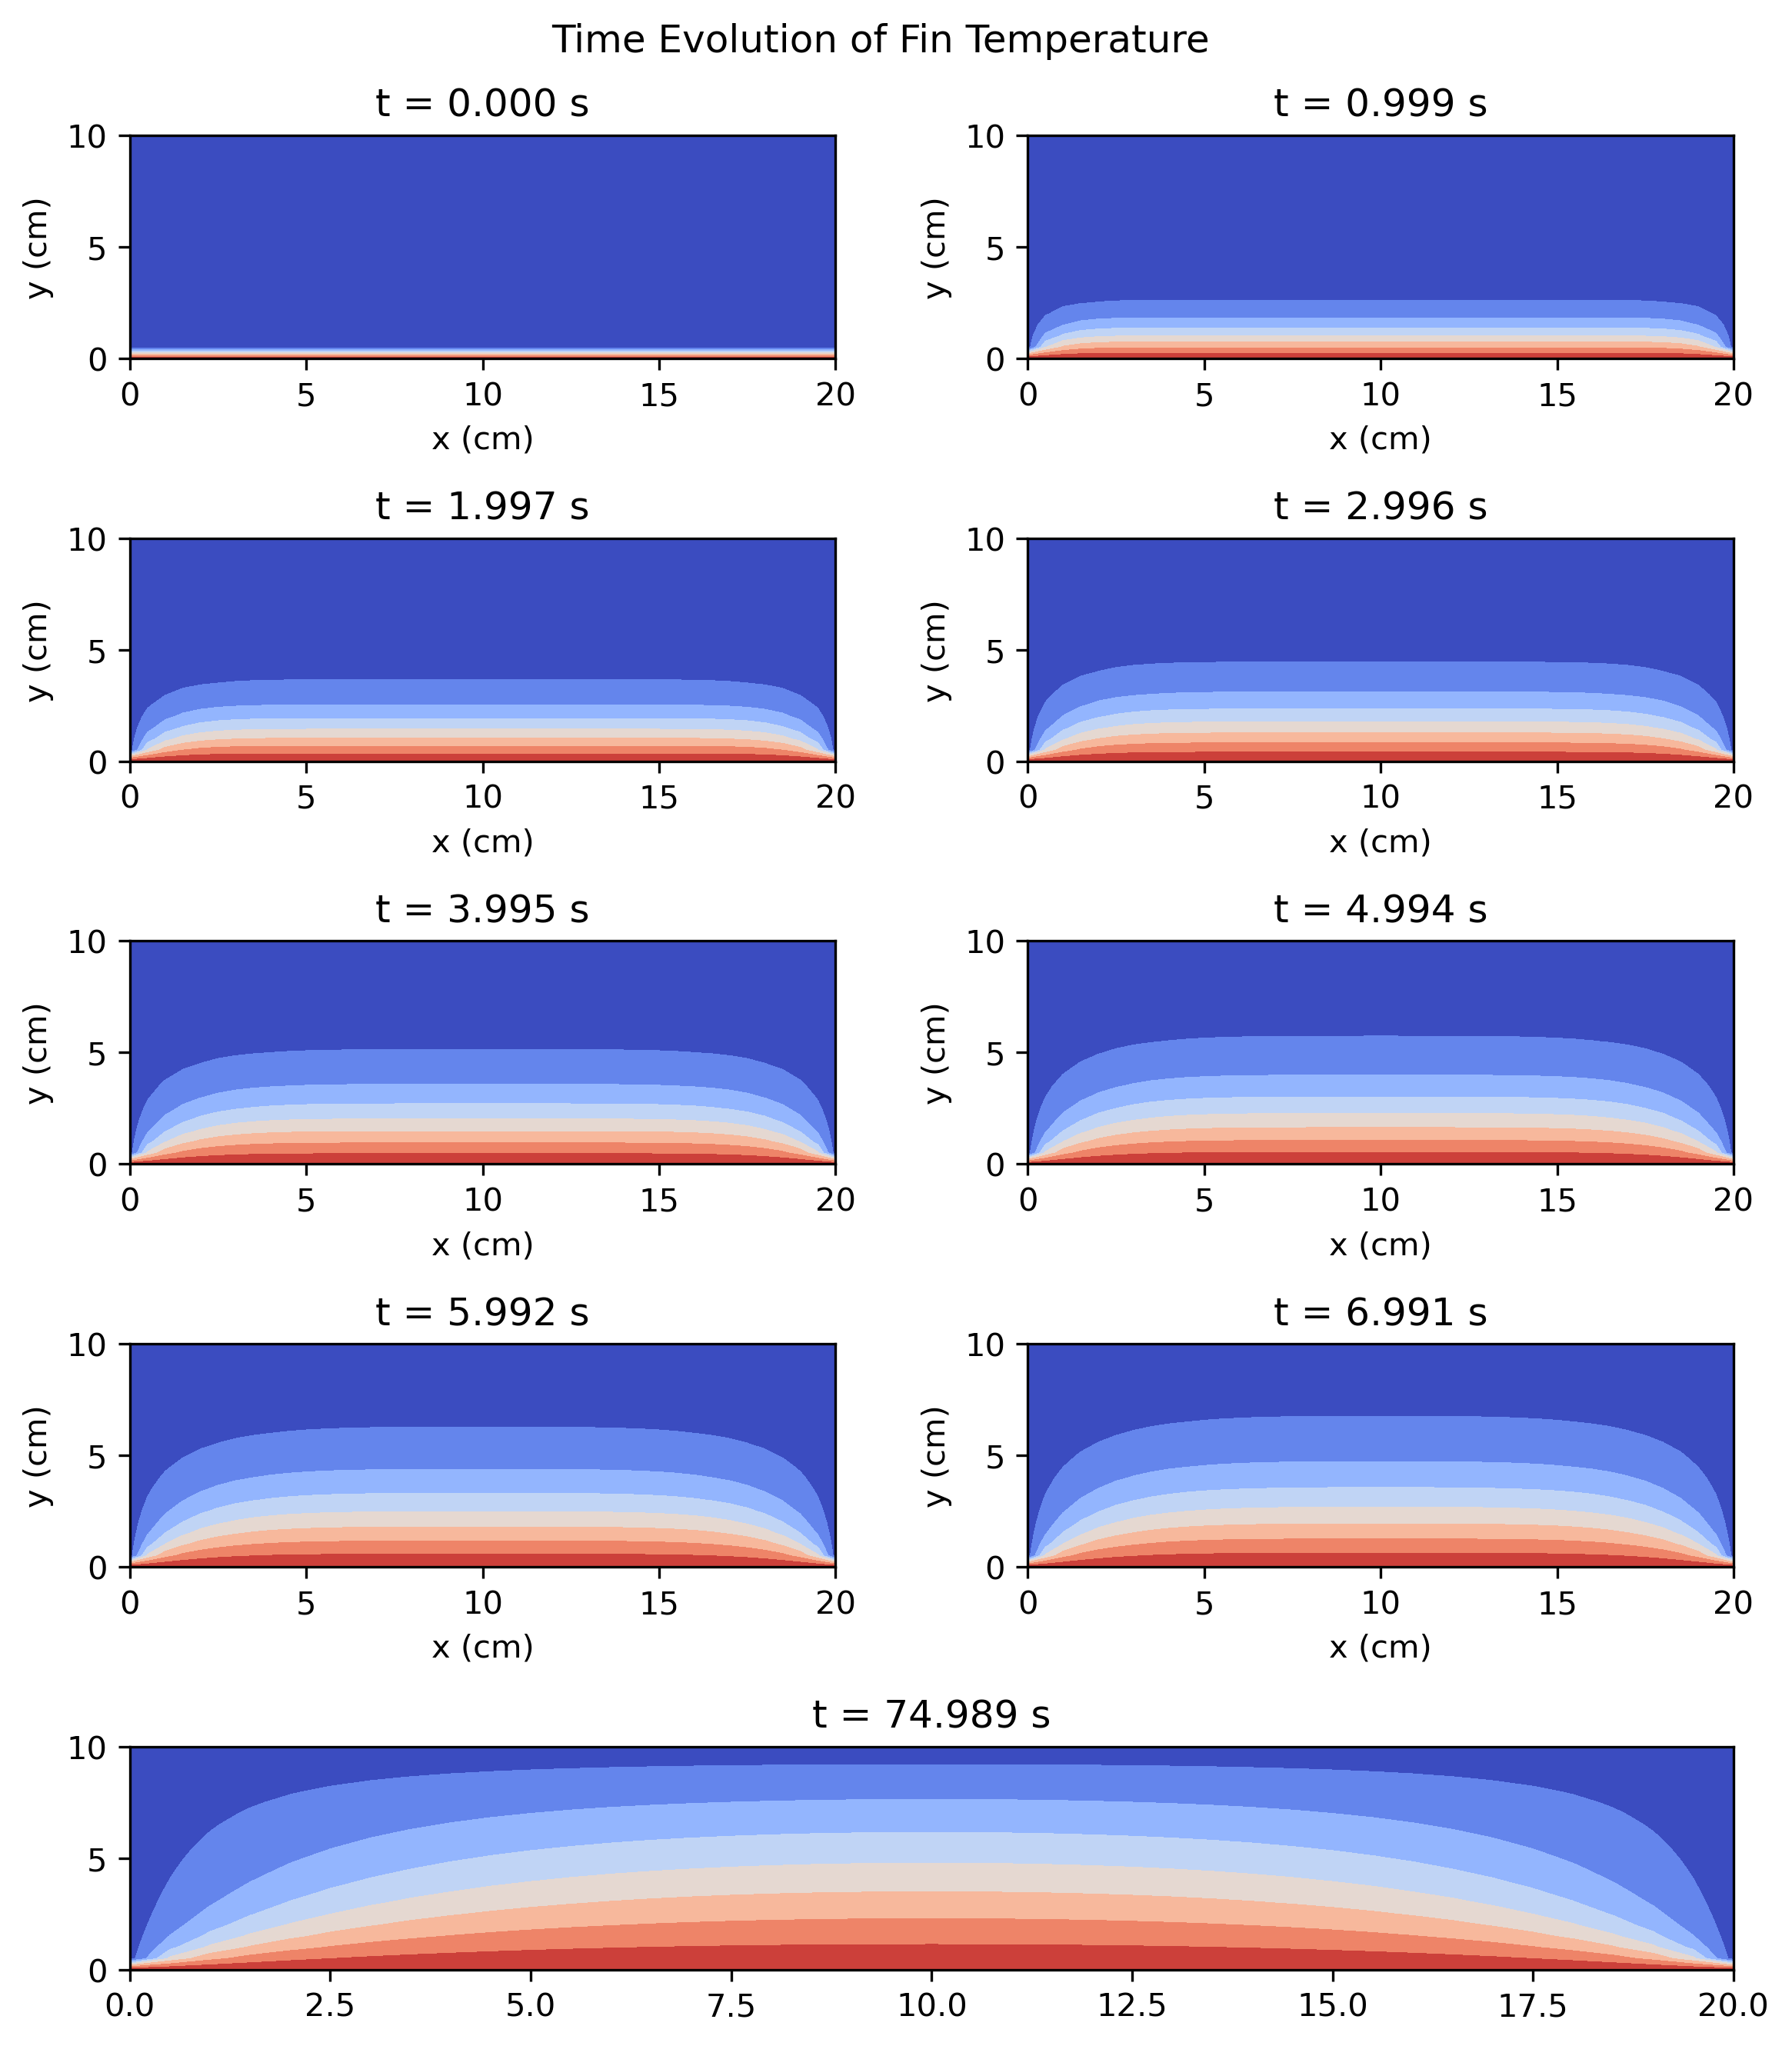

In [16]:
sec_subd = int(len(ts)/tfc) # indecies per second

sec_lim_ind_c = (8 + 1) * sec_subd # index for an upper bound time (s)
nplot_rows = 4 
nplot_columns = 2
nplots = nplot_rows * nplot_columns + 1

# plotting subsection of solutions at regular t values
fig4 = plt.figure(figsize=(8, 9))
for i in range(1,nplots):
    i_index = int((i-1)*sec_lim_ind_c/nplots)
    
    n = fig4.add_subplot(nplot_rows+1, nplot_columns, i)
    n.contourf(Xc, Yc, T_ts[i_index], cmap= plt.cm.coolwarm, vmin = 300)
    #n.pcolormesh(Xc, Yc, T_ts[i_index], cmap= plt.cm.coolwarm, vmin = 300, shading='auto') #shading could also be gouraud
    n.set_title(f't = {ts[i_index]:.3f} s')
    n.set_xlabel('x (cm)')
    n.set_ylabel('y (cm)')

axf = fig4.add_subplot(nplot_rows+1, 1, nplot_rows+1)
# axf.pcolormesh(Xc, Yc, T_ts[-1], cmap= plt.cm.coolwarm, vmin = 300, shading='auto')
axf.contourf(Xc, Yc, T_ts[-1], cmap= plt.cm.coolwarm, vmin = 300)
axf.set_title(f't = {ts[-1]:.3f} s')

fig4.suptitle('Time Evolution of Fin Temperature')
plt.tight_layout()
# plt.pcolormesh(Xc, Yc, T_ts[-1], cmap= plt.cm.coolwarm, shading = 'auto')

# could turn into a function

In [17]:
#What happens to steady state plate if heat source suddenly removed - how will heat dissipate

## **Section (d)**

##### Plot of temperature profile slices along x midpoint at different times

Text(0.5, 1.0, 'Temperature along x=10 cm evolution')

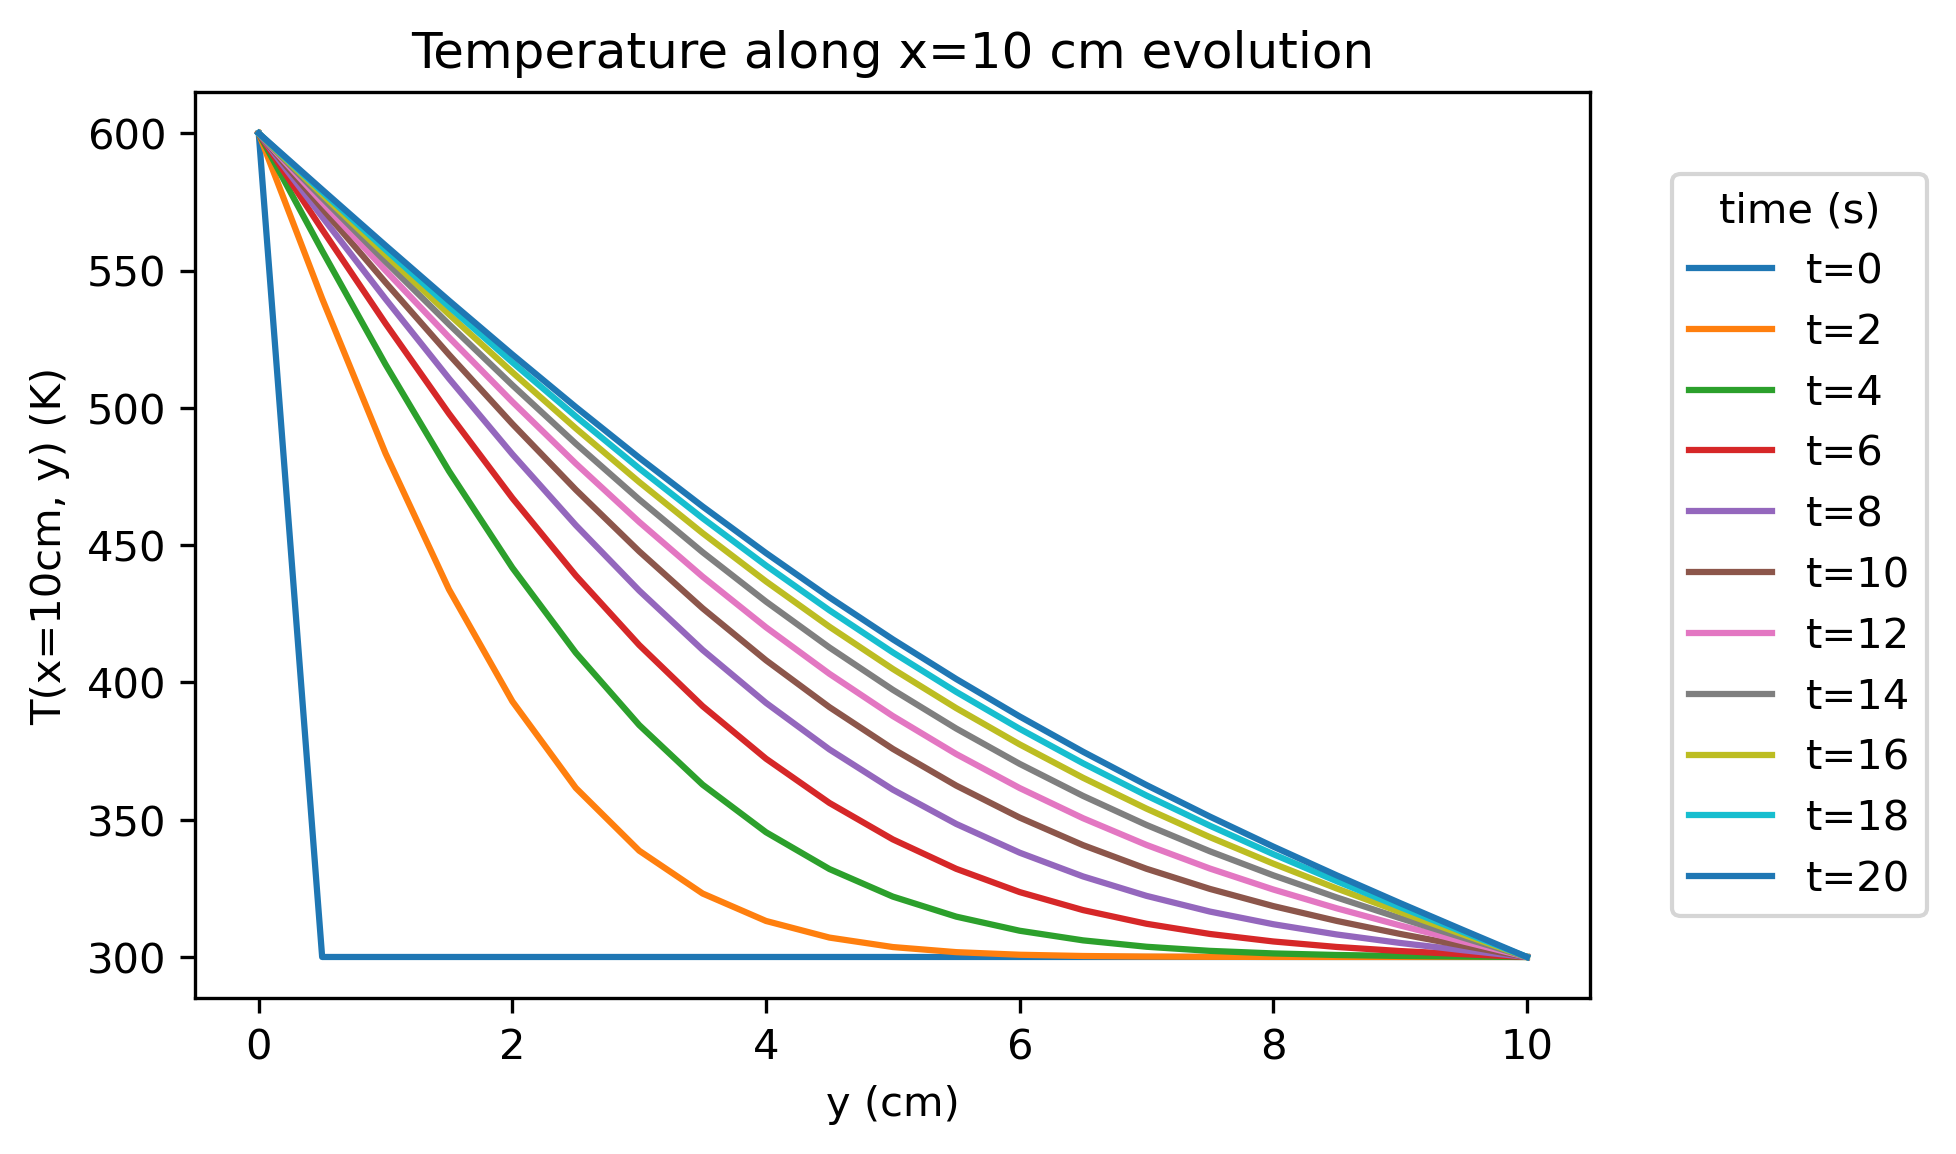

In [18]:
#adopts time evolution from section c instance (T_ts)
fig5 = plt.figure()
ax1 = fig5.add_subplot()

sec_step = 2
sec_lim_ind_d = (20 + 1) * sec_subd

for i, t in enumerate(ts[ : sec_lim_ind_d : sec_step*sec_subd ]):
    #print(ts[sec_step*n*sec_subd], np.ceil(t))
    ax1.plot(yvecc, T_ts[sec_step*i*sec_subd, :, int((nxc-1)/2)], label=f't={int(np.ceil(t))}')

ax1.legend(loc='center', bbox_to_anchor=(1.15,0.5), title='time (s)')
ax1.set_xlabel('y (cm)')
ax1.set_ylabel('T(x=10cm, y) (K)')
ax1.set_title('Temperature along x=10 cm evolution')

## **Section (e)**

##### Plot of temperature at midpoint over time

Text(0.5, 1.0, 'Midpoint Temperature vs Time')

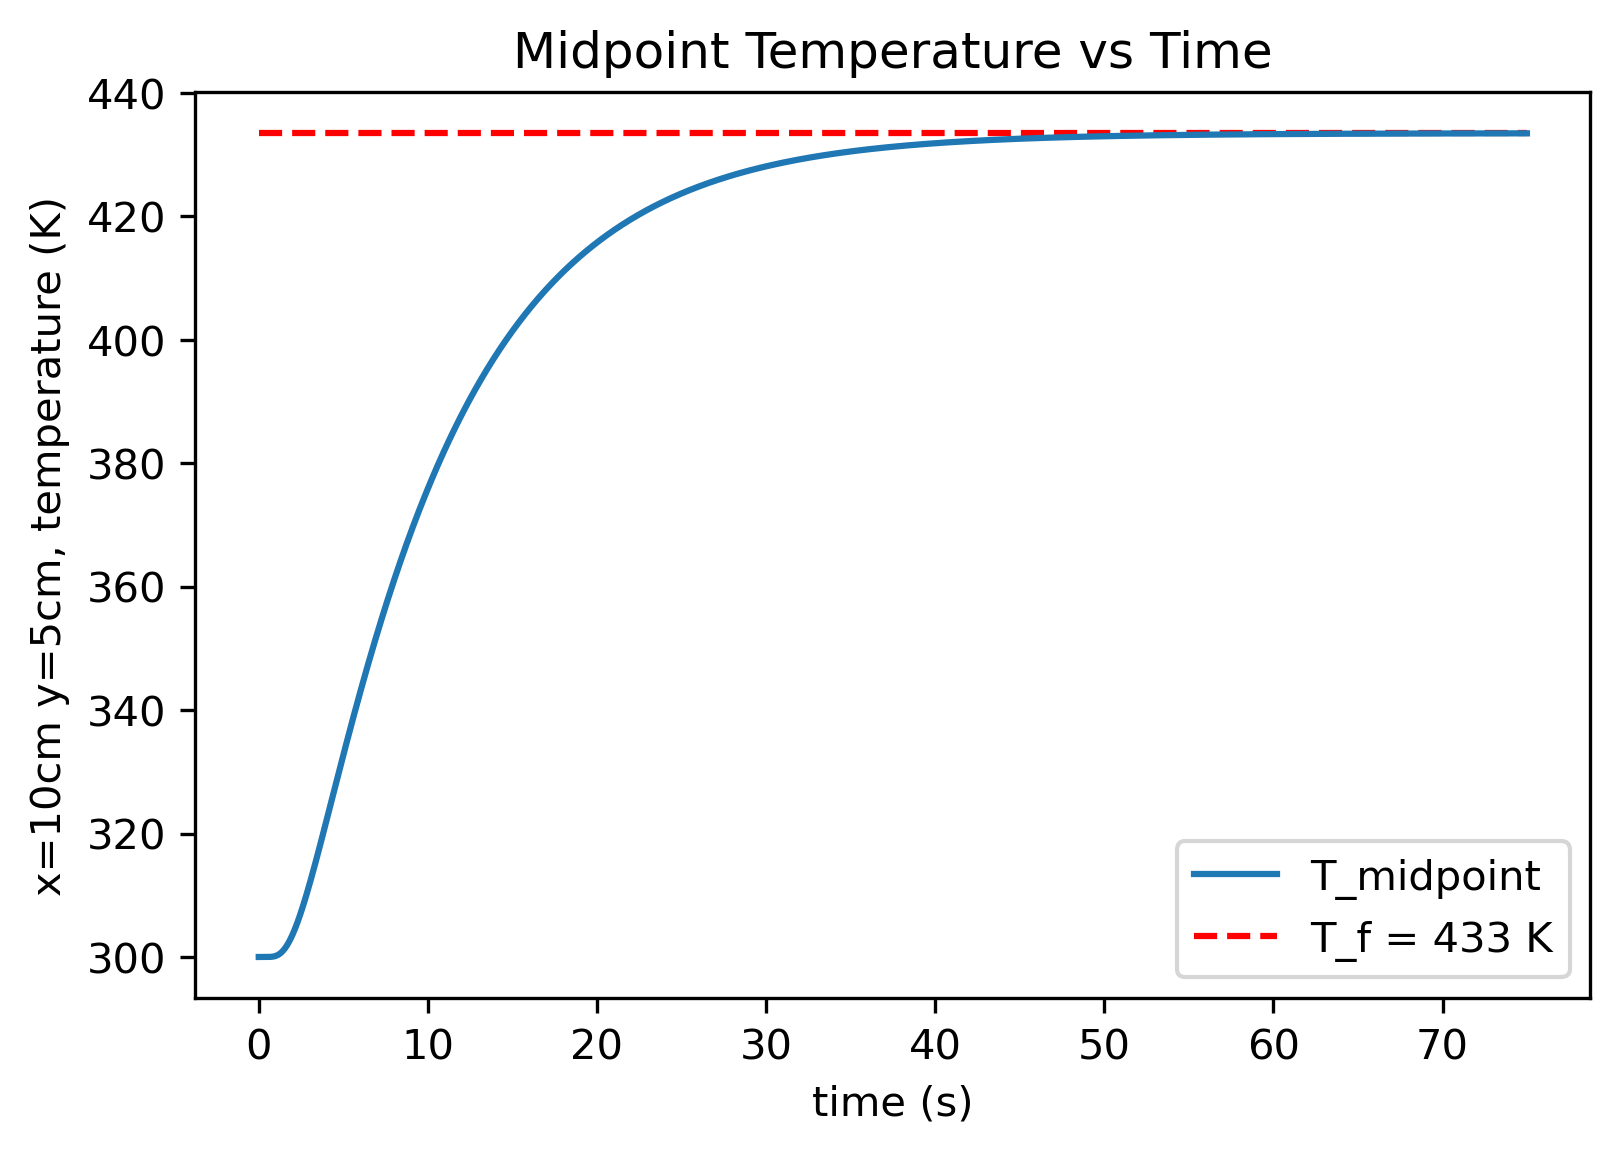

In [19]:
#adopts time dep values from section (c)
plt.plot(ts, T_ts[:, int((nyc-1)/2), int((nxc-1)/2)], label='T_midpoint')
final_T_e = T_ts[-1, int((nyc-1)/2), int((nxc-1)/2)]
plt.hlines(final_T_e, ts[0], ts[-1], 'r', linestyle='--', label = f'T_f = {final_T_e:.0f} K')
plt.xlabel('time (s)')
plt.ylabel('x=10cm y=5cm, temperature (K)')
plt.legend()
plt.title('Midpoint Temperature vs Time')
#consider finding tao

The curve resembles a sigmoid where the initial positive curvature in temperature indicates the approach of heat flowing from the heat source–the bottom edge–then from neighboring points, and the latter negative curvature represents the approaching of a single temperature as the plate reaches steady state, and the heat flow reaches an equilibrium.

## **Section (f)**

Constant temperature is a Dirichlet boundary condition, insulation is a Neumann boundary condition.

##### Function **lm_insulated_upper_x** defined

In [20]:
# uses finite difference approximation to model neumann upper bound condtion (insulated)
# takes same aruments as lm_steady_state
# returns T profile for insulated upper bound
def lm_insulated_upper_x(x_range, y_range, bx, by, T0, h, tol, lmda=1.6138383838383838):
    T_0_elements = build_T0(x_range, y_range, bx, by, T0, h, h)
    T, nx, ny, xvec, yvec = T_0_elements[:5]

    #error analysis definitions
    rel_errors = np.zeros_like(T)
    rel_errors[1:ny, 1:nx-1] = np.ones_like(T[1:ny, 1:nx-1])*100 #arbitrary initial error value #arbitrary initial error value
    max_errs = [100]
    stime = time.time()
    
    #matrix population
    while max_errs[-1] > tol:
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                old_val = T[j, i]
                new_val = 1/4*(T[j, i+1] + T[j, i-1] + T[j+1, i] + T[j-1, i])
                new_val = lmda*new_val + (1-lmda)*old_val
                rel_errors[j, i] = np.abs((new_val - old_val)/new_val)
                T[j, i] = new_val
                
            #yf insulation
            old_insul_val = T[-1, i]
            new_insul_val = 1/4*(T[-1, i+1] + T[-1, i-1] + 2*T[-2, i])
            new_insul_val = lmda*new_insul_val + (1-lmda)*old_insul_val
            rel_errors[-1, i] = np.abs((new_insul_val - old_insul_val)/new_insul_val)
            T[-1, i] = new_insul_val
        #print(T[-1,:5], T[-2,:5])
        max_errs.append(np.amax(rel_errors))
    etime = time.time()
    
    return [T, xvec, yvec, np.array(max_errs), (etime-stime)]

##### Conditions and section (f) instantiation of insulated, steady-state solution

In [21]:
#function call for steady state
x_bcs_f = (600, 300)
y_bcs_f = (450, 300)
T_init_f = 300
sq_intervalf = 0.2
er_tolf = 10**(-4)

T_f_ins = lm_insulated_upper_x(xrange, yrange, x_bcs_f, y_bcs_f, T_init_f, sq_intervalf, er_tolf)
T_insf, xvecf, yvecf, max_errs_f, time_elapsed_f = T_f_ins

#print(T_ins[-1,:])
#print(time_elapsed_f)

##### Insulated upper bound, steady-state contour plots

Text(0, 0.5, 'y (cm)')

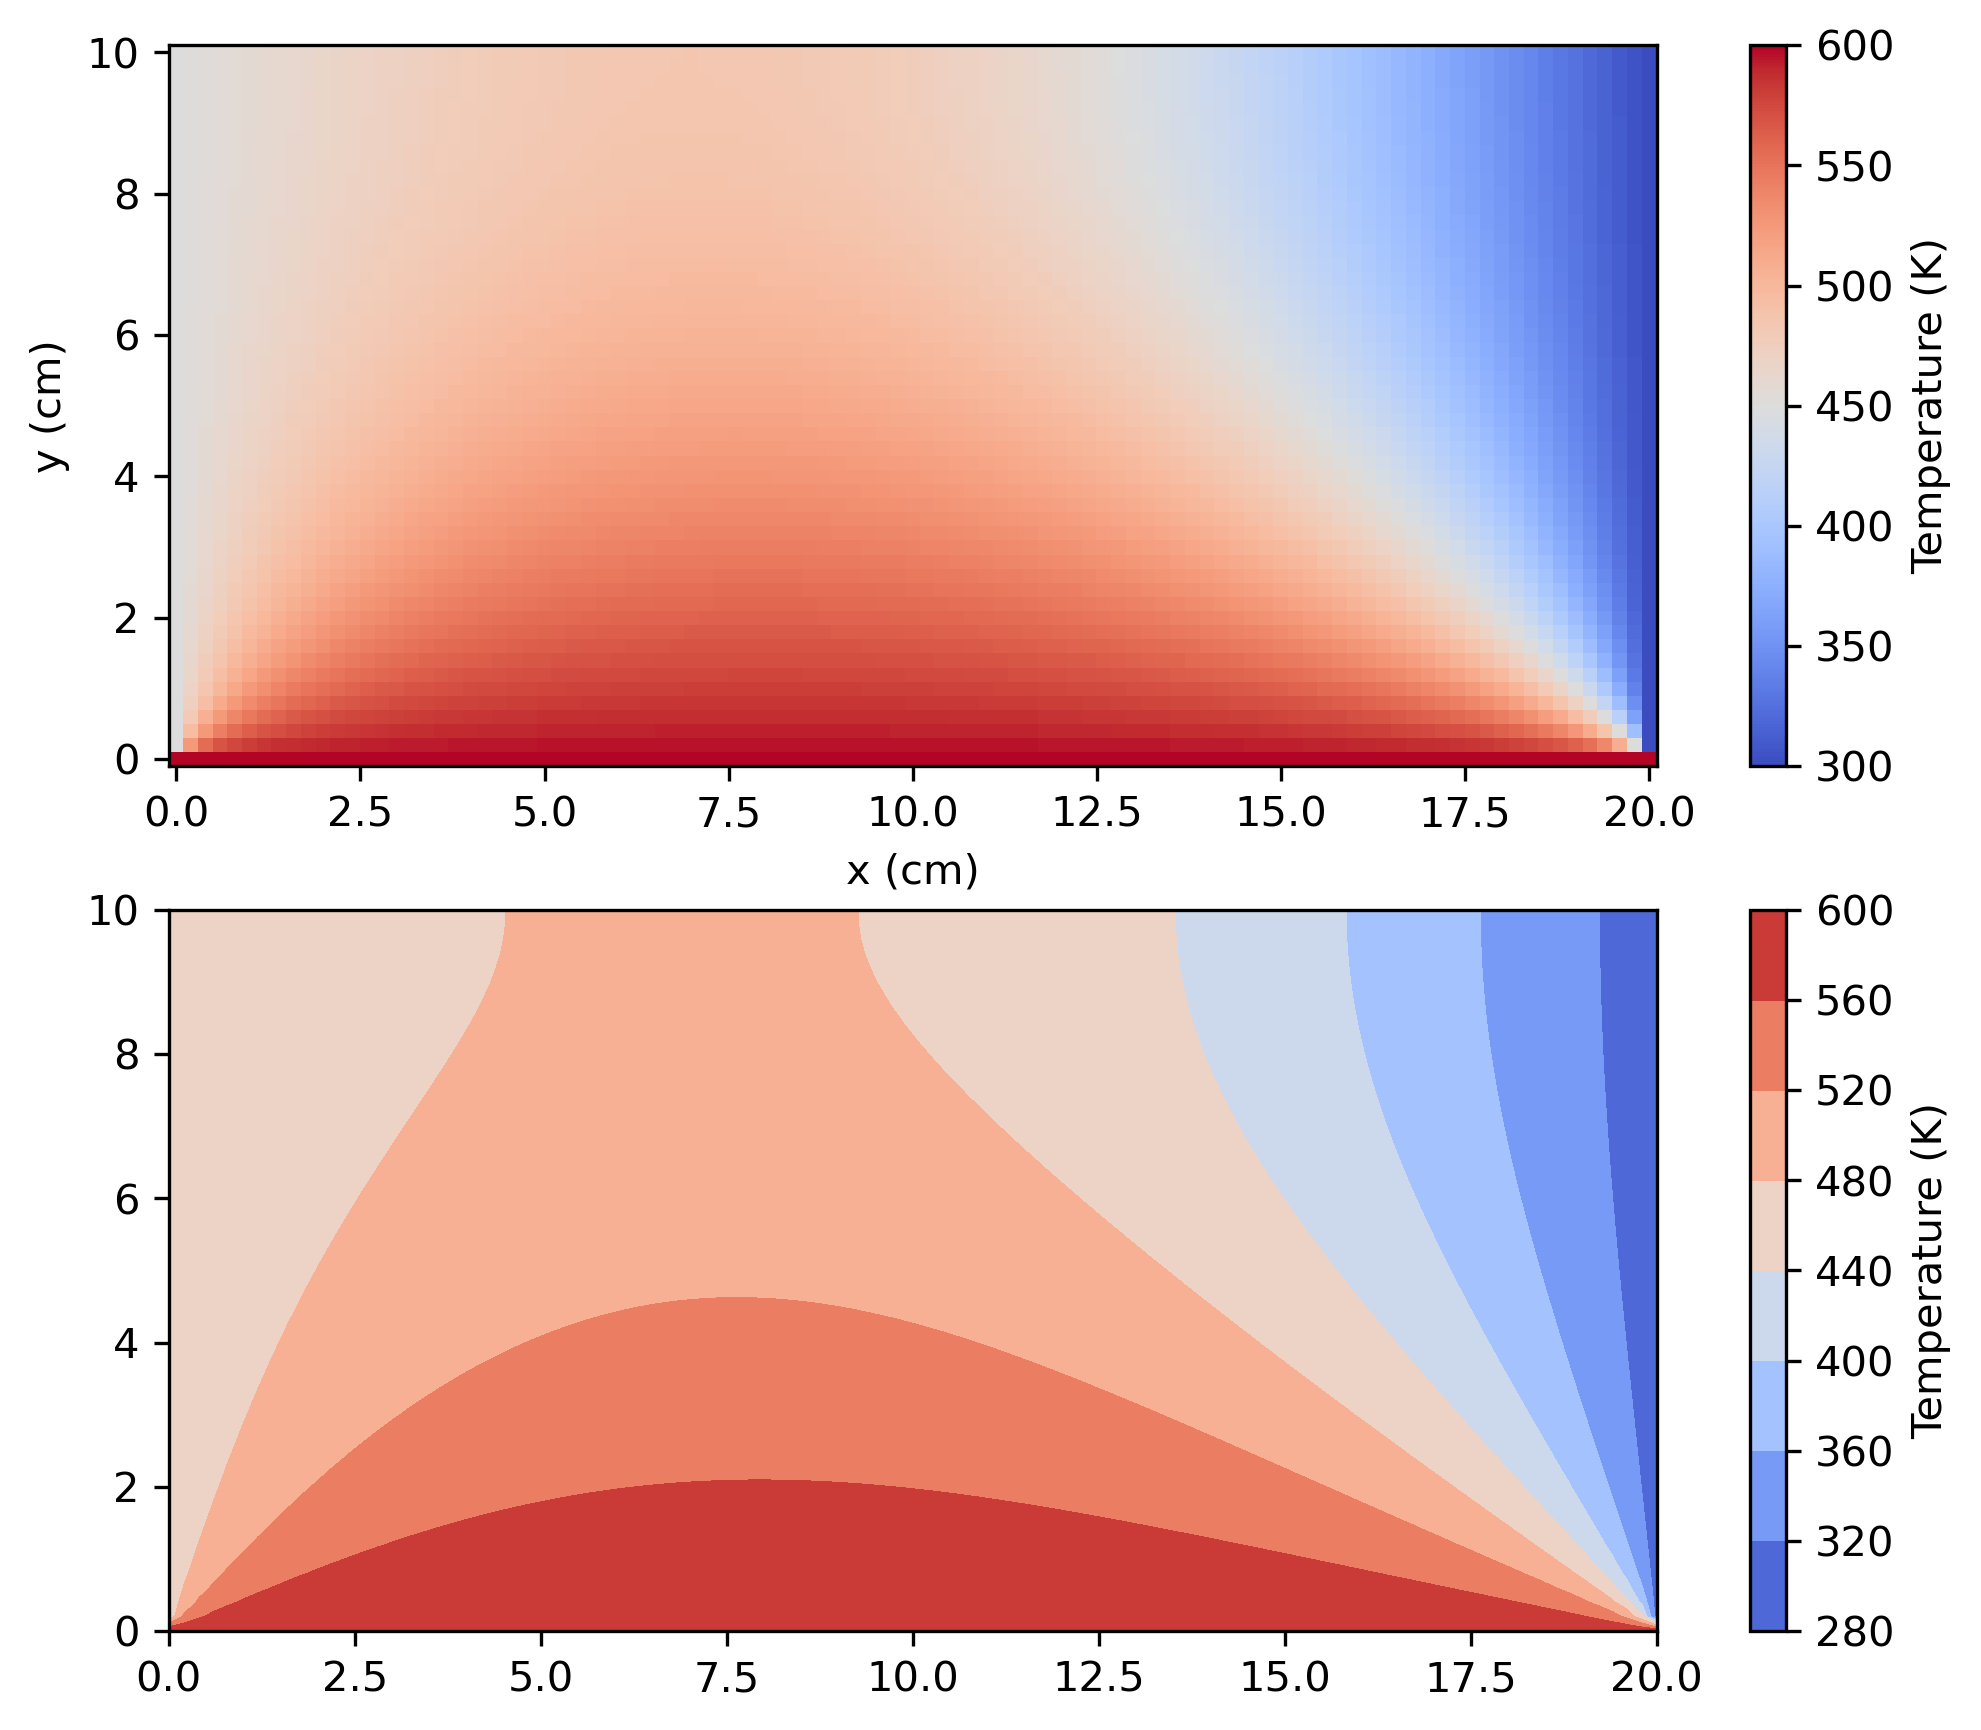

In [22]:
#Contour plotting
Xf, Yf = np.meshgrid(xvecf, yvecf)

fig6 = plt.figure(figsize = (8,7))
ax1 = fig6.add_subplot(211)

p6 = ax1.pcolormesh(Xf, Yf, T_insf, cmap = plt.cm.coolwarm, shading = 'auto') #shading could also be 'auto'
cb1 = fig6.colorbar(p6, ax=ax1, label='Temperature (K)')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')

ax2 = fig6.add_subplot(212)

ct = ax2.contourf(Xf, Yf, T_insf, cmap=plt.cm.coolwarm)
cb2 = fig6.colorbar(ct, ax=ax2, label='Temperature (K)')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')

##### Function **heat_flux** defined

In [23]:
#Finds sum of heat flux for each boundary
#heat flux = qhat dot N hat ds

#takes steady state temperature profile, whether insulated upper bound, and include flux from bottom
#returns total heat exiting or total flux per time; total heat entering per time is the difference of the two
#also I am assuming a default fin width of 1mm to return heat flux in units of W
def boundary_heat_flux(T_steady_state, xvec, yvec, h,  k, width=0.001, ins=False, total_flux=False):
    
    q_return = q(T_steady_state, h, h, k)
    #heat vecs in differentiable range (1 back from the edge set of points)
    #becomes a better approximation as h decreases
    qx_inrange = q_return[1][1:-1,1:-1]
    qy_inrange = q_return[2][1:-1,1:-1]
    
    qtot = 0
    # flux along x = 0: integrate q dot -i_hat dy from y0 to yf = -q_xcomponent dy from y0 to yf
    qflux_x0 = scipy.integrate.simpson(-1*qx_inrange[:,0], yvec[1:-1]/100)
    # flux along x = 20: integrate q dot i_hat dy from y0 to yf = q_xcomponent dy from y0 to yf
    qflux_xf = scipy.integrate.simpson(qx_inrange[:,-1], yvec[1:-1]/100)
    
    qtot += qflux_x0 + qflux_xf
    
    if not ins:
        # flux along y = 10: integrate q dot j_hat dx from x0 to xf = q_ycomponent dx from x0 to xf
        qflux_yf = scipy.integrate.simpson(qy_inrange[-1,:], xvec[1:-1]/100)
        qtot += qflux_yf
    if total_flux:
        # flux along y = 0: integrate q dot -j_hat dx from x0 to xf = -q_ycomponent dx from x0 to xf
        qflux_y0 = scipy.integrate.simpson(-1*qy_inrange[0,:], xvec[1:-1]/100)
        qtot += qflux_y0
        
    return width*qtot

##### Insulated upper bound, steady-state $\vec{q}$ quiver plot, and heat flux

Total heat flux at steady state: -0.0013 W
Total heat dissipated at steady state: 0.0243 W


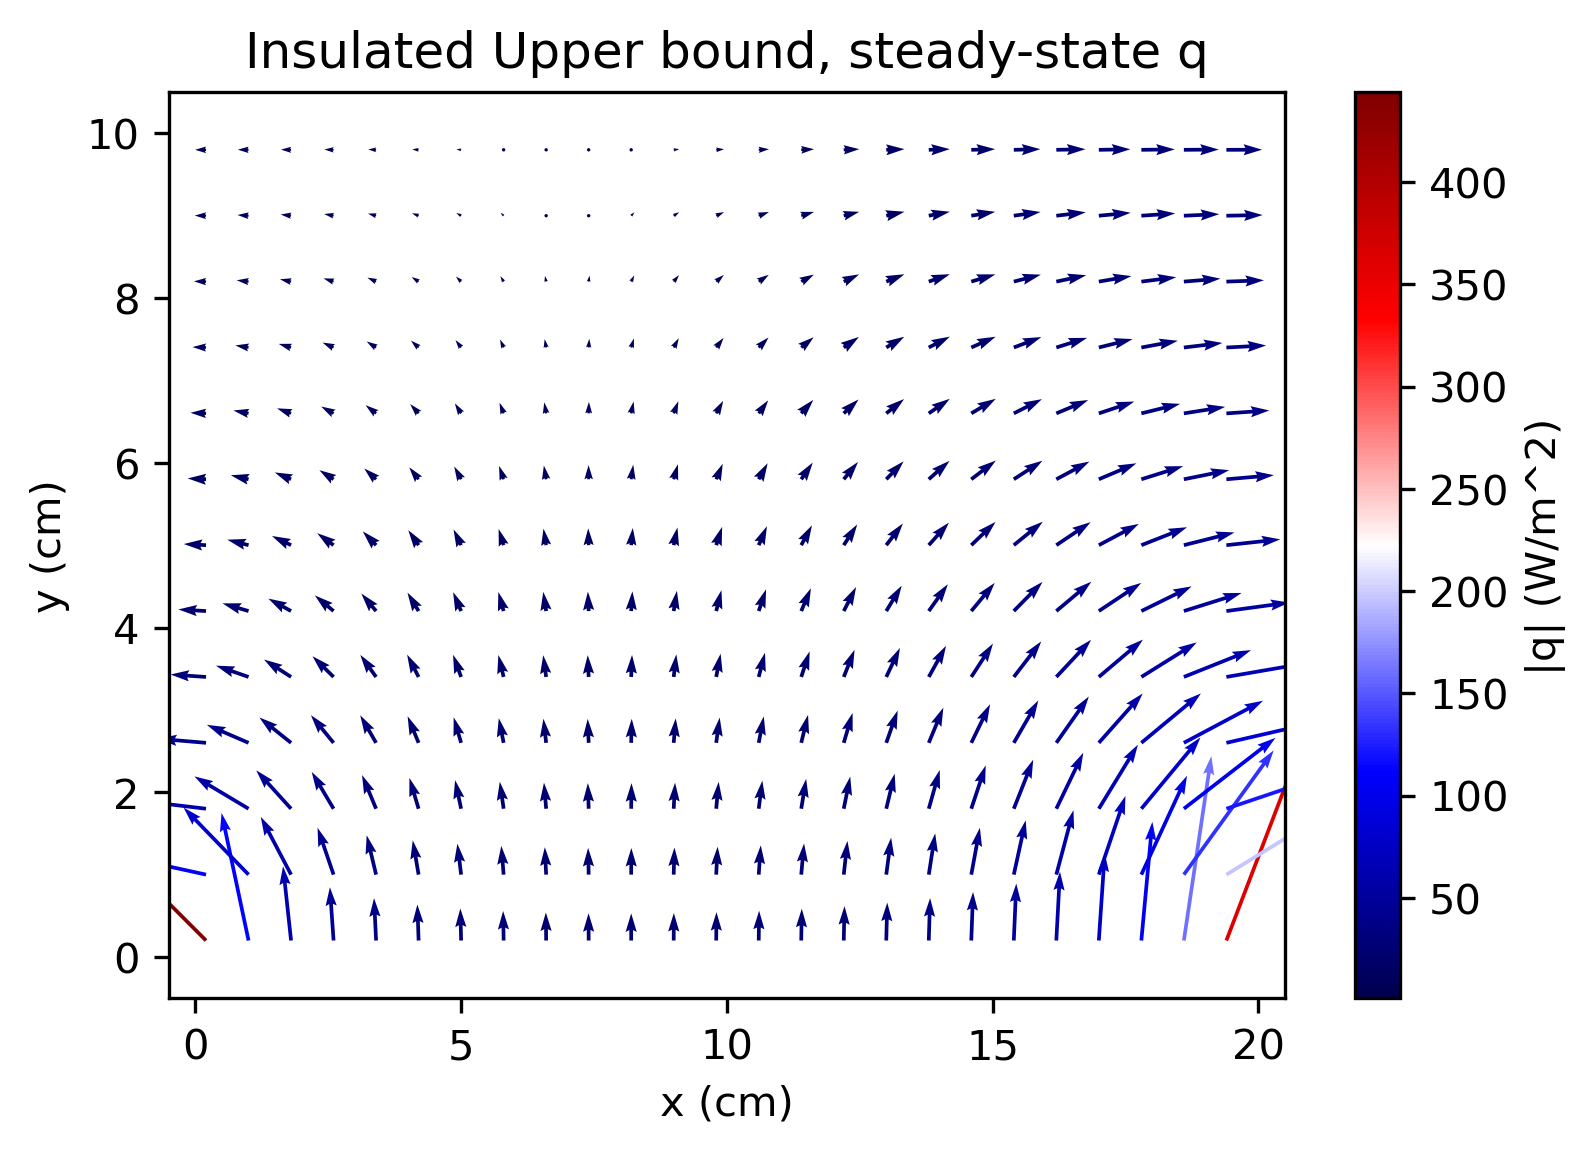

In [24]:
#q steady state, insulated, upper bound, steady-state solution
q_matrix_f = q(T_insf, sq_intervalf, sq_intervalf, k_plate)
Xf, Yf = np.meshgrid(xvecf, yvecf)

fig, ax1 = plt.subplots()
q1 = ax1.quiver(Xf[1:-1:4,1:-1:4], Yf[1:-1:4,1:-1:4], q_matrix_f[1][1:-1:4,1:-1:4], q_matrix_f[-1][1:-1:4,1:-1:4], q_matrix_f[0][1:-1:4,1:-1:4], cmap=plt.cm.seismic, pivot='tail')
fig.colorbar(q1, ax=ax1, label='|q| (W/m^2)')
ax1.set_xlim(-0.5,20.5)
ax1.set_ylim(-0.5,10.5)
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')
ax1.set_title('Insulated Upper bound, steady-state q')

heat_flux_f_total = boundary_heat_flux(T_insf, xvecf, yvecf, sq_intervalf, k_plate, ins=True, total_flux=True)
heat_flux_f_dissipated = boundary_heat_flux(T_insf, xvecf, yvecf, sq_intervalf, k_plate, ins=True, )
print(f'Total heat flux at steady state: {heat_flux_f_total:.4f} W')
print(f'Total heat dissipated at steady state: {heat_flux_f_dissipated:.4f} W')

I would expect the total heat flux to be 0 because the flux of q should = integral of divergence of $\vec{q} = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0$ by the steaady state elliptical PDE equation.


It is potentially not 0 because the underlying approximation of the edges of the Temperature matrix being the first and last rows/columns makes $q$ along those points undefined (which are at the boundaries of the plate). Thus the heat vectors used to calculate the flux are from the next closest rows/columns which are within the boundaries. This error would resolve itself as h decreases, because the next columns and rows would approach the boundary; although, the computational complexity scaling exorbitantly with smaller h makes it hard to test that this would resolve the error.


Of course, an experimental model of the plate would not have 0 flux because heat would be lost to the environment in the middle of the plate; although this idealized model should still have 0 flux because the middle of the plate is assumed to be insulated, meaning heat could only enter and leave through the boundaries - additionally no heat is generated or consumed in the region of the plate and heat cannot accumulate because the plate is being considered at steady-state.

## **Section (g)**


##### Conditions and section (g) instantiations for exemplary insulated, steady-state T and $\vec{q}$ solutions

In [25]:
# uses lm_insulated_upper_x defined in the previous section
sq_interval_g = 0.7

#Solution to insulated upper edge version of original (old) bc
T_g_ins_old = lm_insulated_upper_x(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, sq_interval_g, er_tol)
T_insg_old, xvec_g_old, yvec_g_old, max_errs_g_old, time_elapsed_g_old = T_g_ins_old

#Solution to q steady state old boundary conditions
q_matrix_old = q(T_insg_old, sq_interval_g, sq_interval_g, k_plate)
Xg, Yg = np.meshgrid(xvec_g_old, yvec_g_old)

#Solution to insulated upper edge with new bc
T_g_ins_new = lm_insulated_upper_x(xrange, yrange, x_bcs_f, y_bcs_f, T_init_f, sq_interval_g, er_tol)
T_insg_new, xvec_g_new, yvec_g_new, max_errs_g_new, time_elapsed_g_new = T_g_ins_new

#q steady state new boundary conditions
q_matrix_new = q(T_insg_new, sq_interval_g, sq_interval_g, k_plate)

##### Overlayed contour and quiver plots of exemplary insulated solutions

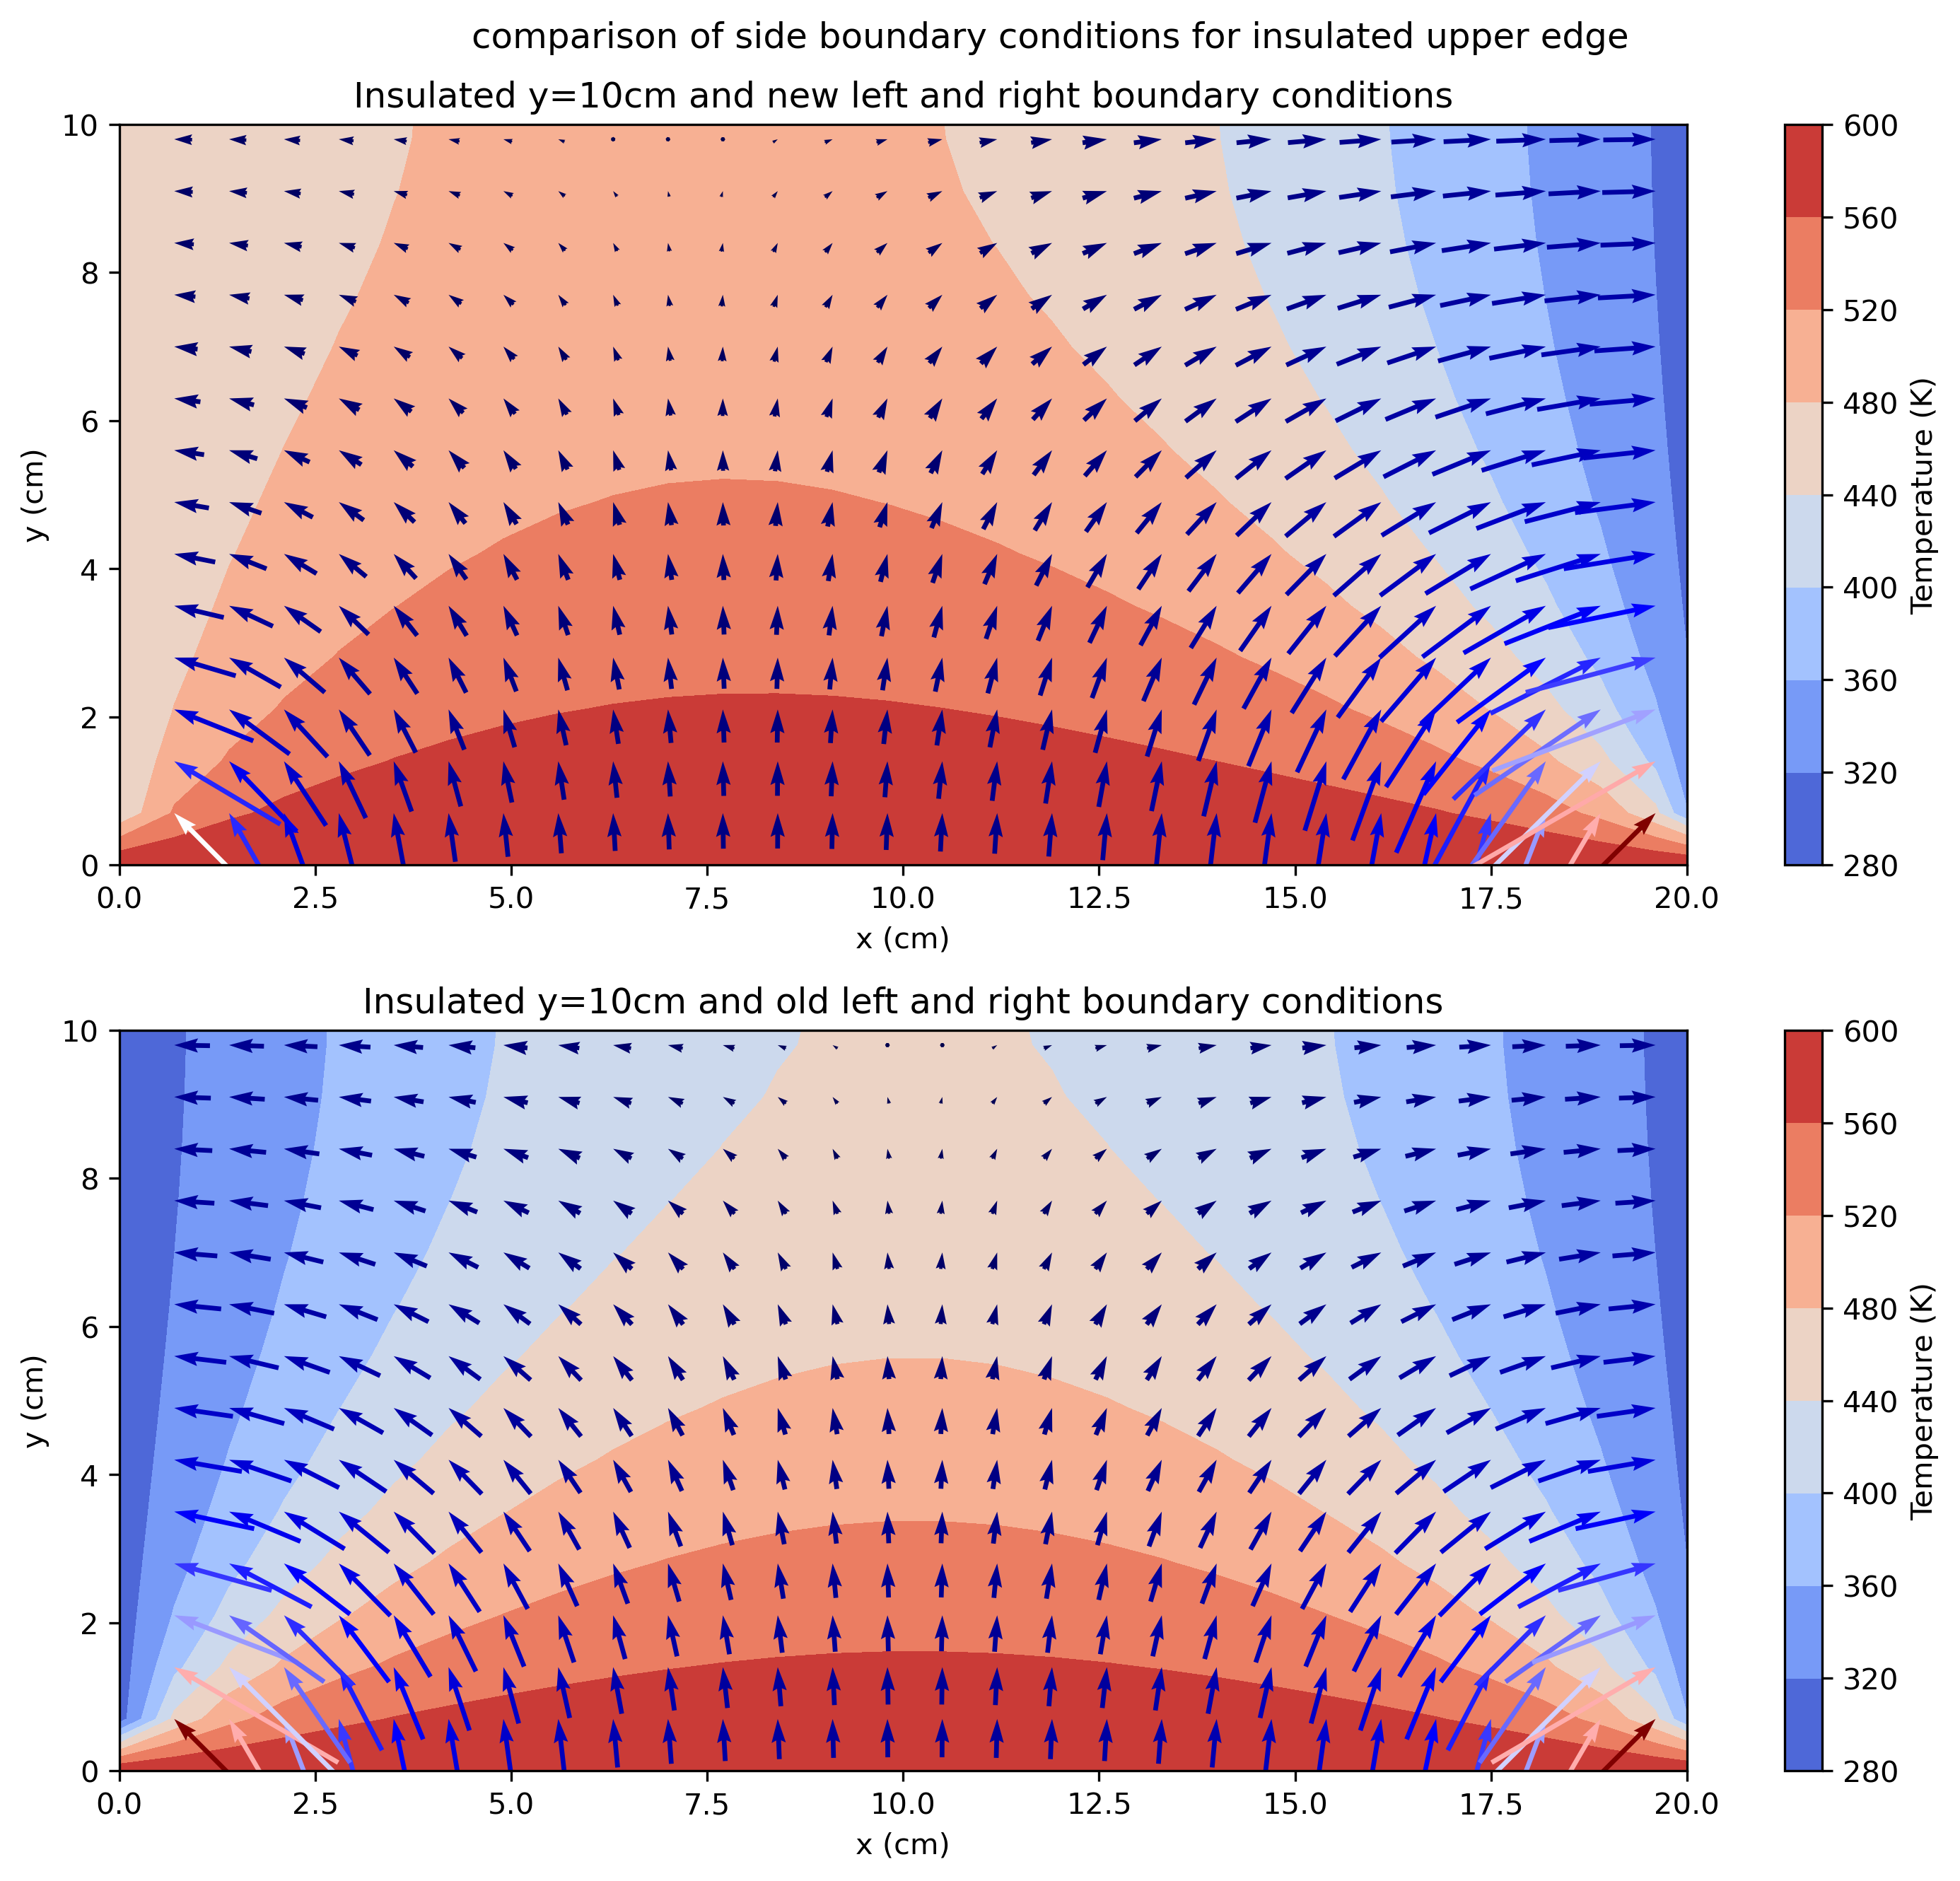

In [26]:
fig6 = plt.figure(figsize = (10,9))
ax1 = fig6.add_subplot(211)
ax2 = fig6.add_subplot(212)

#new bc T steady state
#p6 = ax1.pcolormesh(Xf, Yf, T_insf, cmap = plt.cm.coolwarm, shading = 'gouraud') #shading could also be 'auto'
c6 = ax1.contourf(Xg, Yg, T_insg_new, cmap = plt.cm.coolwarm)
cb1 = fig6.colorbar(c6, ax=ax1, label='Temperature (K)')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('y (cm)')
ax1.set_title('Insulated y=10cm and new left and right boundary conditions')

#old bc T steady state
#p7 = ax2.pcolormesh(Xg, Yg, T_insg, cmap = plt.cm.coolwarm, shading = 'gouraud') #shading could also be 'auto'
c7 = ax2.contourf(Xg, Yg, T_insg_old, cmap = plt.cm.coolwarm)
cb2 = fig6.colorbar(c7, ax=ax2, label='Temperature (K)')
ax2.set_xlabel('x (cm)')
ax2.set_ylabel('y (cm)')
ax2.set_title('Insulated y=10cm and old left and right boundary conditions')

#new bc q steady state
q6 = ax1.quiver(Xg[1:-1,1:-1], Yg[1:-1,1:-1], q_matrix_new[1][1:-1,1:-1], q_matrix_new[-1][1:-1,1:-1], q_matrix_new[0][1:-1,1:-1], cmap=plt.cm.seismic, pivot='tip')
ax1.set_xlim(0,20)
ax1.set_ylim(0,10)

#old bc q steady state
q7 = ax2.quiver(Xg[1:-1,1:-1], Yg[1:-1,1:-1], q_matrix_old[1][1:-1,1:-1], q_matrix_old[-1][1:-1,1:-1], q_matrix_old[0][1:-1,1:-1], cmap=plt.cm.seismic, pivot='tip')
ax2.set_xlim(0,20)
ax2.set_ylim(0,10)

fig6.suptitle('comparison of side boundary conditions for insulated upper edge')
plt.tight_layout()

In comparing with and without the insulated upper edge: the primary difference, for the insulated plate, is that heat only flows out the left and right sides. This is observed in only left and right facing heat vectors at the boundaries on the subplots above. 
As a result, the temperature is higher across the center of the plate because more heat accumulates there while the plate reaches steady-state than when heat also could exit through the top. The temperature gradient across the upper edge is indicative of this accumulated heat spreading out to the left and right heat sinks. The insulation of the top boundary creates larger heat vectors on the right and left edges which can be thought of as the insulation of the top boundary forcing more heat out through the sides.

In comparing just the new and old side boundary conditions, having different left and right steady state temperatures makes the temperature distrobution no longer symetric about x=10cm. With the new boundary conditions there is focus of heat moving to the right because the temperature gradient is steeper in that direction. Additionally, the warmer left side allows for more heat to accumulate in the center while reaching steady state accounting for a larger central warm section.

## **Section (h)**

##### Section (h) instantiation of Temperature profiles for new, insulated and old, not-insulated plate conditons
##### Conditions inherited from initial case and new, insulated case

In [27]:
T_h_new, xvec_new, yvec_new = lm_insulated_upper_x(xrange, yrange, x_bcs_f, y_bcs_f, T_init_f, 0.2, 10**(-4))[:3]
T_h_old, xvec_old, yvec_old = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, 0.2, 10**(-4))[:3]

##### Section (h) instantiation of **boundary_heat _flux**  for old and new case

In [28]:
total_new = boundary_heat_flux(T_h_new, xvec_new, yvec_new, 0.2, k_plate, ins=True, total_flux=False)
total_old = boundary_heat_flux(T_h_old, xvec_old, yvec_old, 0.2, k_plate, total_flux=False)
print(f'Total heat lost per second- old, uninsulated boundary conditions: {total_old} W\nTotal heat lost per second- new, insulated boundary conditions: {total_new} W')

Total heat lost per second- old, uninsulated boundary conditions: 0.03597833341165583 W
Total heat lost per second- new, insulated boundary conditions: 0.024268748777209196 W


The old boundary conditions result in higher total heat dissipation per second which makes intuitive sense because there is more arclength for the heat to disipate from and thus the steady state will equilibriate to more heat flowing in and out of the plate.

The total heat disipated (at steady state) is expressed here in Watts, but it can also be expressed in Joules by multiplying by seconds.

##### Analysis of results: test of divergence theorem

In [29]:
total_new_test = boundary_heat_flux(T_h_new, xvec_new, yvec_new, 0.1, k_plate, ins=True, total_flux=True)
total_old_test = boundary_heat_flux(T_h_old, xvec_old, yvec_old, 0.1, k_plate, total_flux=True)
total_heat_flux_test = (total_new_test, total_old_test)
print(total_heat_flux_test)

(-0.002681435937137216, -0.001945152076046952)


I would expect both to be 0 because the flux of q should = integral of divergence of $\vec{q} = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0$ by the steaady state elliptical PDE equation.


These are potentially not 0 because the underlying approximation of the edges of the Temperature matrix being the first and last rows/columns makes $q$ along those points undefined (which are at the boundaries of the plate). Thus the heat vectors used to calculate the flux are from the next closest rows/columns which are within the boundaries. This error would resolve itself as h decreases, because the next columns and rows would approach the boundary; although, the computational complexity scaling exorbitantly with smaller h makes it hard to test that this would resolve the error.


Of course, an experimental model of the plate would not have 0 flux because heat would be lost to the environment in the middle of the plate; although this idealized model should still have 0 flux because the middle of the plate is assumed to be insulated, meaning heat could only enter and leave through the boundaries - additionally no heat is generated or consumed in the region of the plate and heat cannot accumulate because the plate is being considered at steady-state.

##### Analysis of heat flux reliance on h

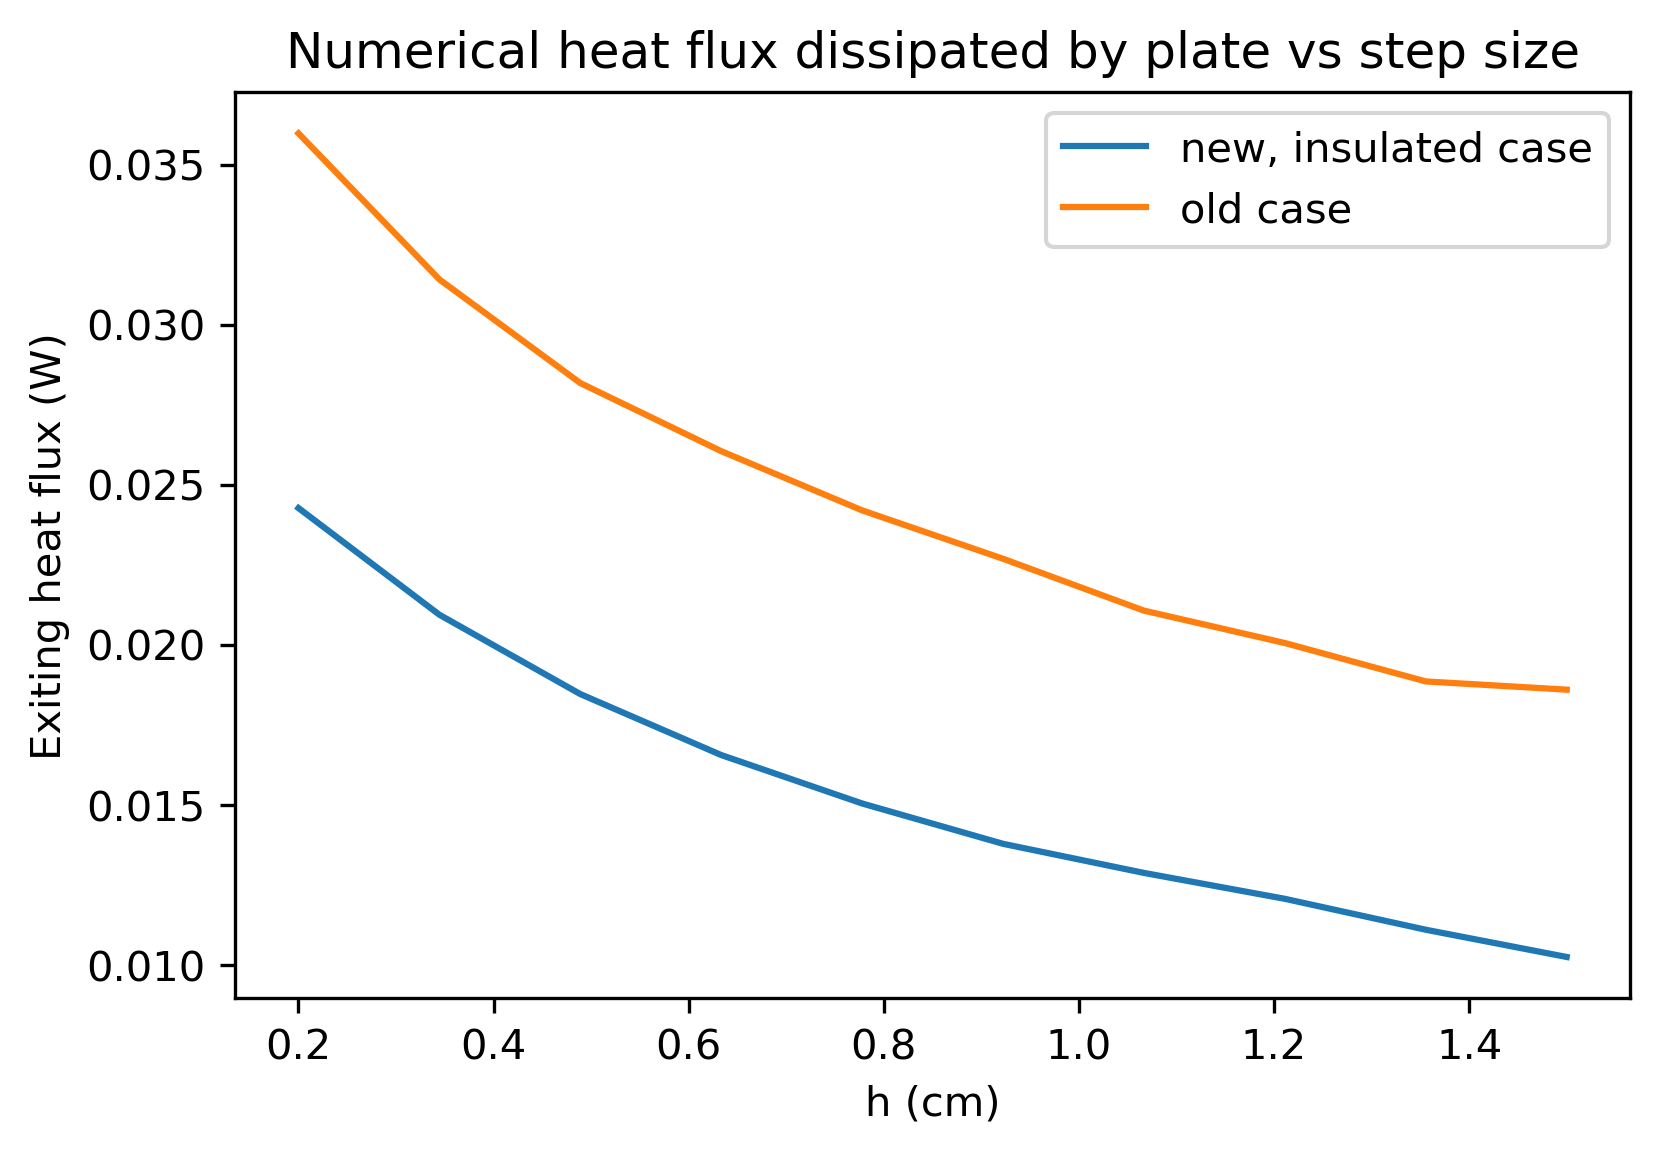

In [30]:

hvec_h = np.linspace(1.5,0.2, 10)
total_heats_ins = []
total_heats = []
for hi in hvec_h:
    T_h_i_ins, xvec_ins, yvec_ins = lm_insulated_upper_x(xrange, yrange, x_bcs_f, y_bcs_f, T_init_f, hi, 10**(-4))[:3]
    T_h_i_heat_ins = boundary_heat_flux(T_h_i_ins, xvec_ins, yvec_ins, hi, k_plate, ins=True)
    total_heats_ins.append(T_h_i_heat_ins)
    
    T_h_i, xvec_not_ins, yvec_not_ins = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, hi, 10**(-4))[:3]
    T_h_i_heat = boundary_heat_flux(T_h_i, xvec_not_ins, yvec_not_ins, hi, k_plate, ins=False)
    total_heats.append(T_h_i_heat)

plt.plot(hvec_h, total_heats_ins, label='new, insulated case')
plt.plot(hvec_h, total_heats, label = 'old case')
plt.xlabel('h (cm)')
plt.ylabel('Exiting heat flux (W)')
plt.title('Numerical heat flux dissipated by plate vs step size')
plt.legend()

The positive curvature of these graphs potentially suggest that as h -> 0 better resembling the model, the heat flux dissipated would -> $\infty$, which would not make physical sense. This could be due to the ever closer T = 600K bottom boundary condition and the T != 600K side boundary conditions becoming closer and making the heat flux at the corner go to infinity to achieve the same temperature change in an ever smaller interval. Of course such boundary conditions would also not make physical sense, explaining the $\infty$, because the model is unrealistic, and may only correspond to experimental results over a particular working range.

`The relation that the old case with an uninsulated upper boundary dissipates more heat holds.`

## **Section (i)**

##### Analysis of thermal diffusivity $\alpha$'s

In [31]:
#instances
#only shown for uninsulated case - relationship is assumed to hold
T0_i_aes = build_T0(pdim[0], pdim[1], [600, 300], [300, 300], 300, 1, 1)
T0_i_aes, nxae, nyae, xvecae, yvecae, Xae, Yae = T0_i_aes

t0_aes, tf_aes = 0, 1000
as_vec = np.linspace(10, 1220, 30)
tf_alphas = []
for alpha_i in as_vec:
    tf_ai = cdif_plate_evolution(T0_c, 1.5, 1.5, t0_aes, tf_aes, alpha_i/100, err_stop=True, tol = 10**-3)
    tf_alphas.append(tf_ai)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Time to equilibriate to 10^-3 relative error vs alpha')

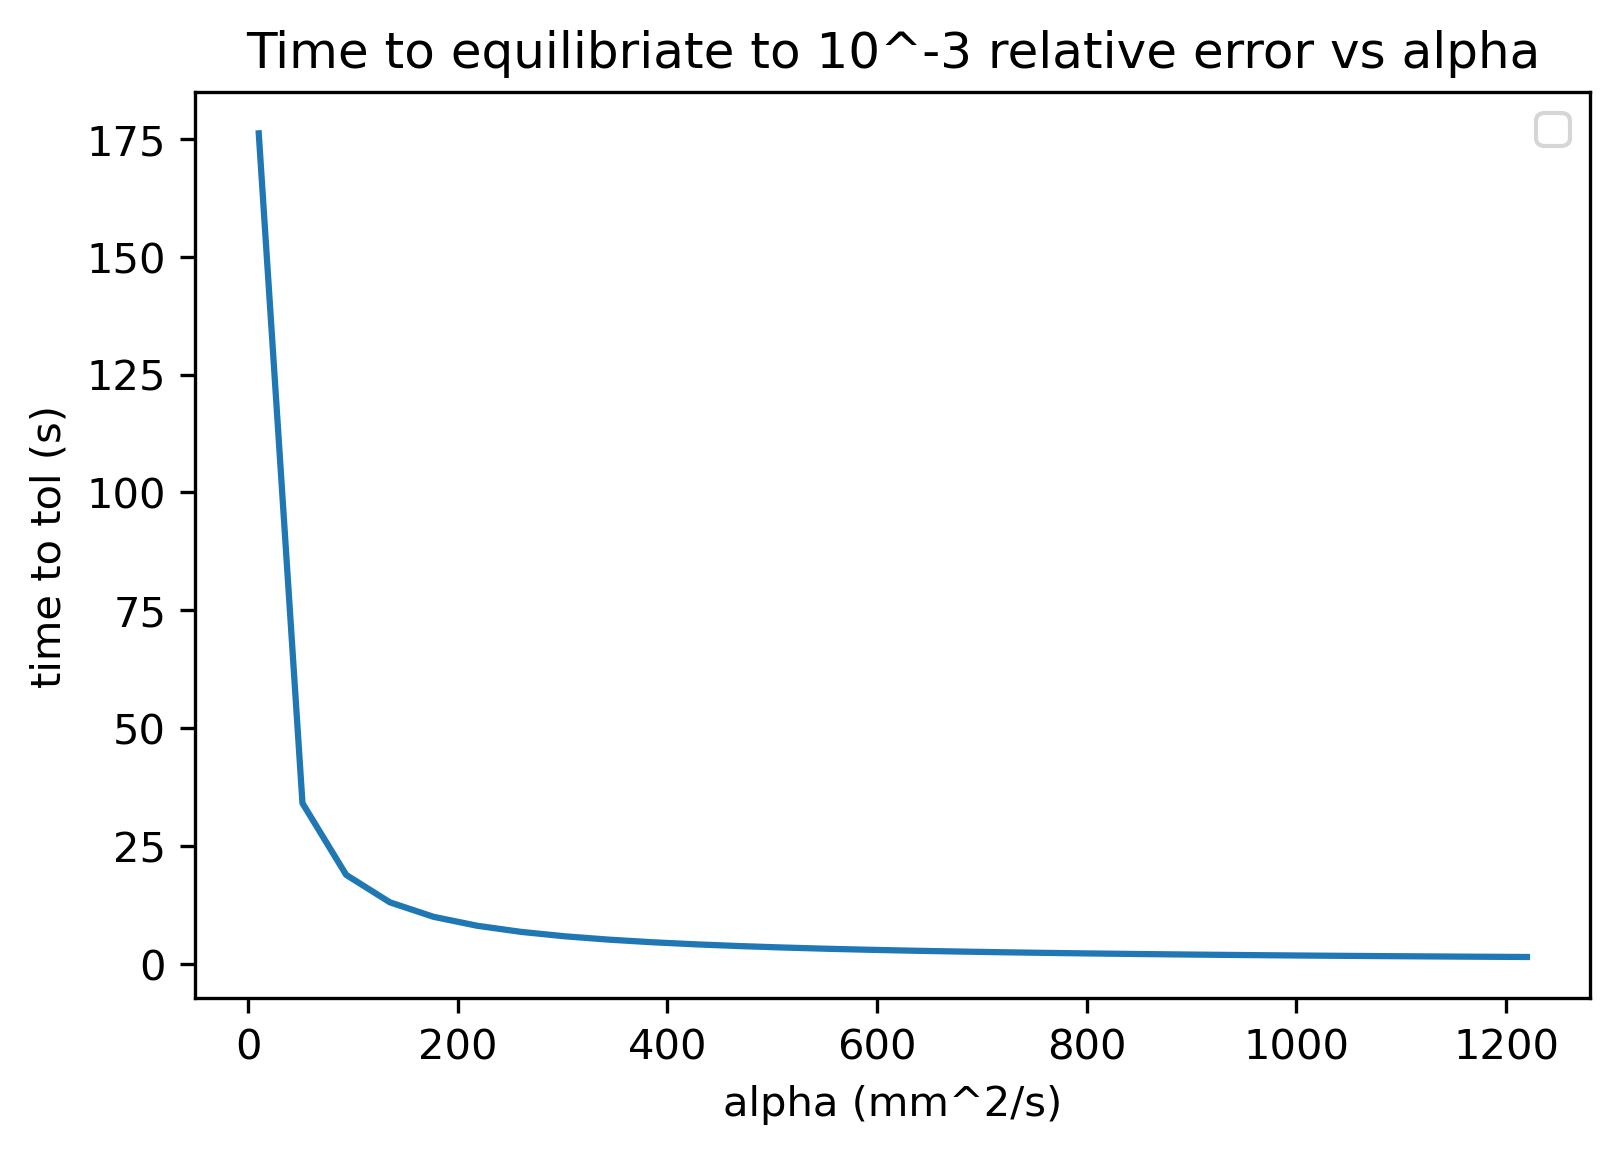

In [32]:
#plot of alpha versus equilibrium time
plt.plot(as_vec, tf_alphas)
plt.xlabel('alpha (mm^2/s)')
plt.ylabel('time to tol (s)')
plt.legend()
plt.title('Time to equilibriate to 10^-3 relative error vs alpha')

As shown in the graph above, the total time for the plate temperature to equilibriate to a constant error falls for larger alpha. It is assumed that the faster time to equilibrium, the greater total heat disipated by the plate, because the plate accumulates heat during the time to reach steady state (as seen by the higher average temperature in the plate at steady state versus initial.
Thus, choosing a plate material with a higher alpha will optimize this period of lower heat dissipation.

##### Analysis of thermal conductivities, k

In [33]:
kvec_i = np.linspace(10,500, 10)
uninsulated_steadystate_elements_i = lm_steady_state(xrange, yrange, x_bcs_a, y_bcs_a, T_init_a, 0.5, 10**(-4))[:3]
T_unins_i, xvec_unins_i, yvec_unins_i = uninsulated_steadystate_elements_i[0:3]

insulated_steadystate_elements_i = lm_insulated_upper_x(xrange, yrange, x_bcs_f, y_bcs_f, T_init_f, 0.5, 10**(-4))[:3]
T_ins_i, xvec_ins_i, yvec_ins_i = insulated_steadystate_elements_i[0:3]

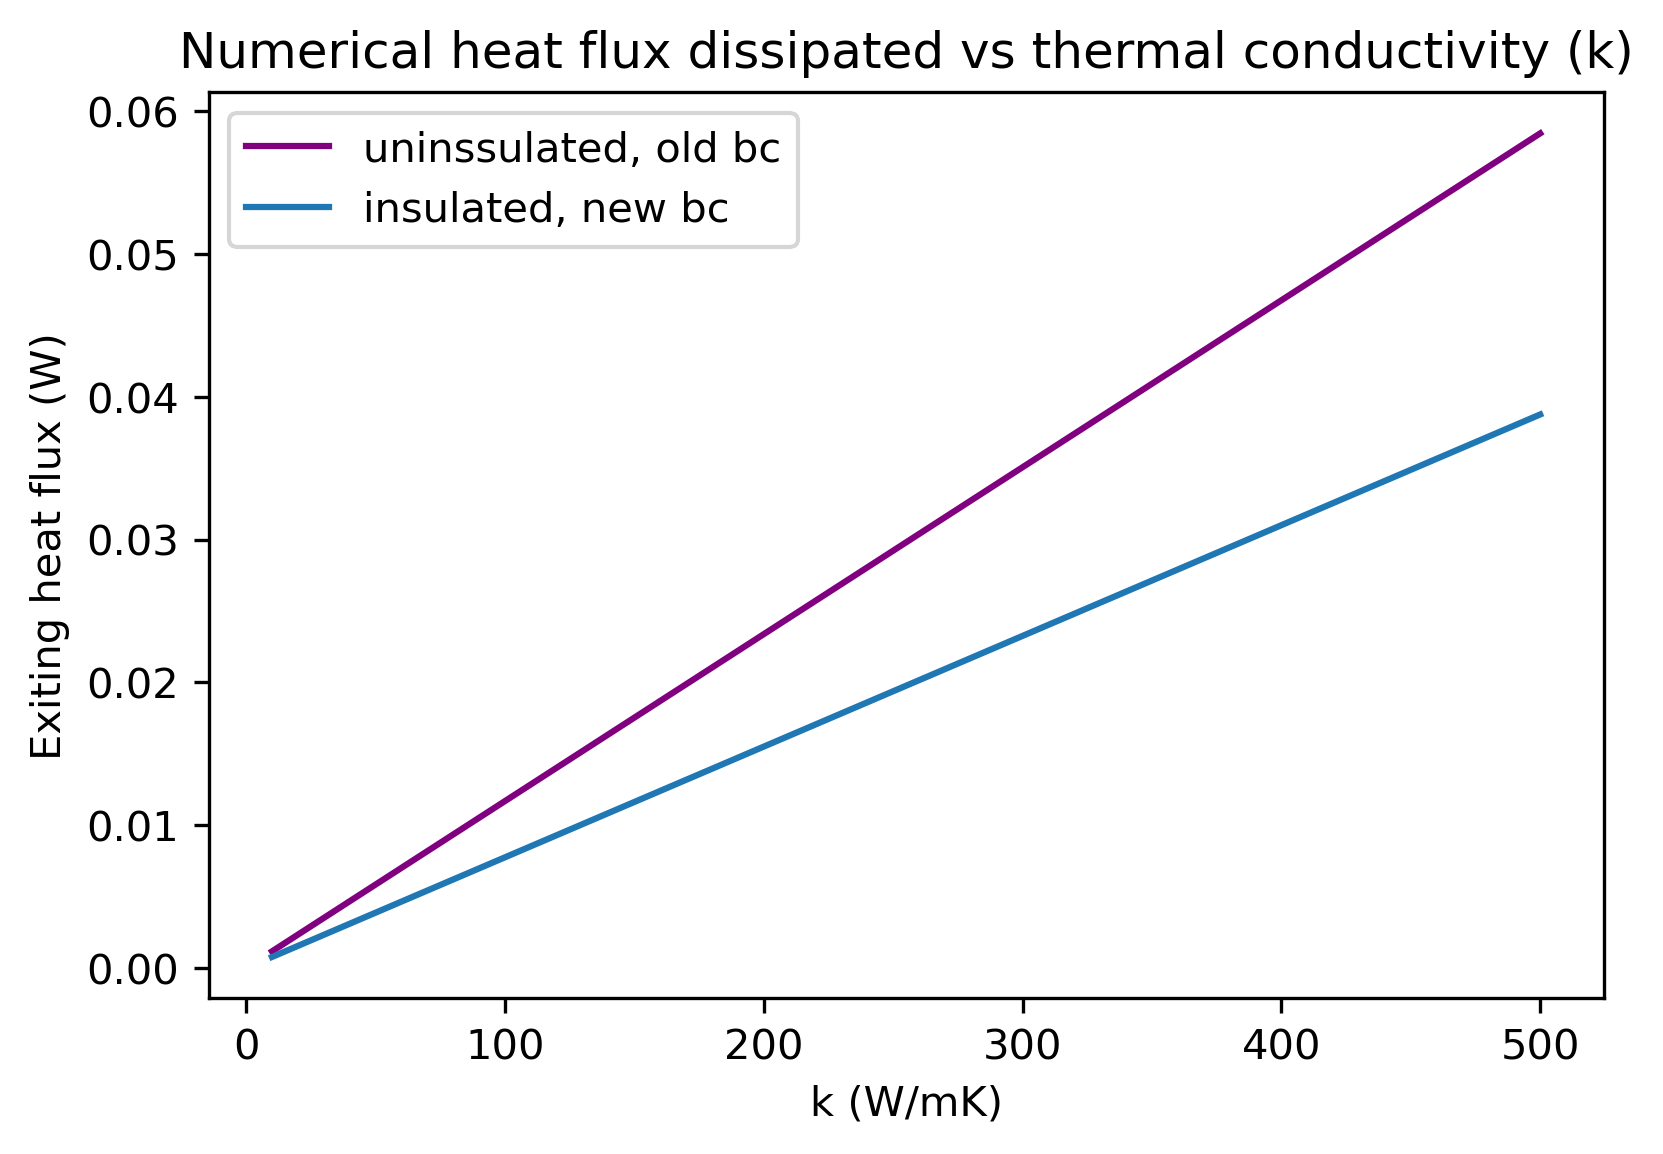

In [34]:
T_h_i_heat = boundary_heat_flux(T_h_i, xvec_not_ins, yvec_not_ins, hi, k_plate, ins=False)
total_heats_ks_unins = []
total_heats_ks_ins = []
for ki in kvec_i:
    total_heat_k_i_unins = boundary_heat_flux(T_unins_i, xvec_unins_i, yvec_unins_i, 0.5, ki, ins=False)
    total_heats_ks_unins.append(total_heat_k_i_unins)
    
    total_heat_k_i_ins = boundary_heat_flux(T_ins_i, xvec_ins_i, yvec_ins_i, 0.5, ki, ins=False)
    total_heats_ks_ins.append(total_heat_k_i_ins)

plt.plot(kvec_i, total_heats_ks_unins, color='purple', label='uninssulated, old bc')
plt.plot(kvec_i, total_heats_ks_ins, label='insulated, new bc')
plt.xlabel('k (W/mK)')
plt.ylabel('Exiting heat flux (W)')
plt.title('Numerical heat flux dissipated vs thermal conductivity (k)')
plt.legend()

As seen above, the heat dissipated by the plate scales proportionally with thermal conductivity (k) which is expected given Fourier's law of heat conduction's linear dependence on k.

It should also be noted that thermal diffusivity is dependent on temperature. In our current model, the thermal diffusivity as well as the the thermal conductivity are assumed to have constant values regardless of temperature.

As a result of this analysis, we see that materials with higher k's have greater overall heat dissipation.

Thus, materials with higher alphas and higher ks seem to optimize the heat sink abilities of the fin.

Although, future models could look to incorperate heat dependent k's and $\alpha$'s to see whether time dependence would create non-synergistic contributions of high $\alpha$ and k during the non-steady state portion and whether boundary conditions which lead to higher temperature steady states result in more or less heat dissipation



In [35]:
#sampling of diffusivity and conductivity
thermal_properties = {'gold':{'alpha': 127, 'k': 292}, 'aluminum':{'alpha': 97, 'k': 240}, 'copper':{'alpha': 111, 'k':383 } , 'silver':{'alpha': 166, 'k':389 }}
print(thermal_properties)

{'gold': {'alpha': 127, 'k': 292}, 'aluminum': {'alpha': 97, 'k': 240}, 'copper': {'alpha': 111, 'k': 383}, 'silver': {'alpha': 166, 'k': 389}}


I would propose that a material like copper would be a better choice of material for the fins, because it has higher thermal diffusivity and conductivity compared to aluminum and would thus dissipate more heat at steady state and reach steady state faster. However, while Copper does improve the performance of the fin, the material would cost more than aluminum so that would be an engineering trade off. I did not suggest Silver, because that would have cost much more than copper with only slightly better properties than copper.